# Problem Definition

Sebagai Data Scientist di ID/X Partners akan terlibat dalam sebuah proyek dari perusahaan pemberi pinjaman (multifinance).

Client ingin **meningkatkan keakuratan** dalam ***menilai dan mengelola risiko kredit***, sehingga dapat mengoptimalkan keputusan bisnis mereka dan mengurangi potensi kerugian.

**Tujuan:** mengembangkan model machine learning yang dapat memprediksi risiko kredit (credit risk) berdasarkan dataset yang disediakan, yang mencakup data pinjaman yang disetujui dan ditolak.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Collection

### Libraries

In [2]:
!pip install category_encoders --quiet
!pip install lightgbm catboost --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.7 MB/s eta 0:00:00


In [3]:
from datetime import datetime
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Warning output handling
import warnings

# Encoding
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import category_encoders as ce

# Normalization
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# Clustering
from sklearn.cluster import KMeans

# Dimensionality Reduction
from sklearn.decomposition import PCA

# Data Splitting
from sklearn.model_selection import train_test_split

# Oversampling
from imblearn.over_sampling import SMOTE

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from catboost import CatBoostClassifier

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Model Training
from sklearn import metrics

# Export model
import joblib

# Confusion matrix
from sklearn.metrics import confusion_matrix

# Precision and Recall
from sklearn.metrics import precision_score, recall_score

# ROC dan AUC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

### Settings

In [4]:
# Atur pandas untuk menampilkan semua kolom
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Atur output warning
warnings.filterwarnings('ignore')

# Atur random state dari SMOTE
smote = SMOTE(random_state=42)

### Read Dataset

In [5]:
'''
* Data utama yaitu file loan_data_2007_2014.csv
* 466285 data
'''
# UNTUK DEVELOPMENT
# 200 data
# df = pd.read_csv("/content/loan_data_200.csv")

# 5000 data
# df = pd.read_csv("/content/loan_data_5000.csv")

# 20000 data
# df = pd.read_csv("/content/loan_data_20000.csv")

# UNTUK PRODUCTION
# df = pd.read_csv("/content/loan_data_2007_2014")
df = pd.read_csv("/content/drive/MyDrive/Machine Learning/Data/loan_data_2007_2014.csv")

# Data Understanding

In [6]:
# Dimensi dataset
df.shape

print(f'Jumlah baris: {df.shape[0]}')
print(f'Jumlah kolom: {df.shape[1]}')

Jumlah baris: 466285
Jumlah kolom: 75


Pada dataset terdapat sebanyak 466285 data dan 75 variabel

In [7]:
column_descriptions = {
    'Unnamed: 0': 'Index',
    'id': 'Loan ID',
    'member_id': 'Member ID',
    'loan_amnt': 'Loan Amount',
    'funded_amnt': 'Funded Amount',
    'funded_amnt_inv': 'Funded Amount by Investors',
    'term': 'Loan Term',
    'int_rate': 'Interest Rate',
    'installment': 'Installment Amount',
    'grade': 'Loan Grade',
    'sub_grade': 'Loan Subgrade',
    'emp_title': 'Employment Title',
    'emp_length': 'Employment Length',
    'home_ownership': 'Home Ownership Status',
    'annual_inc': 'Annual Income',
    'verification_status': 'Income Verification Status',
    'issue_d': 'Issue Date',
    'loan_status': 'Loan Status',
    'pymnt_plan': 'Payment Plan',
    'url': 'URL',
    'desc': 'Description',
    'purpose': 'Loan Purpose',
    'title': 'Loan Title',
    'zip_code': 'ZIP Code',
    'addr_state': 'State',
    'dti': 'Debt-to-Income Ratio',
    'delinq_2yrs': 'Delinquencies in Last 2 Years',
    'earliest_cr_line': 'Earliest Credit Line',
    'inq_last_6mths': 'Credit Inquiries in Last 6 Months',
    'mths_since_last_delinq': 'Months Since Last Delinquency',
    'mths_since_last_record': 'Months Since Last Public Record',
    'open_acc': 'Number of Open Accounts',
    'pub_rec': 'Number of Public Records',
    'revol_bal': 'Revolving Balance',
    'revol_util': 'Revolving Utilization',
    'total_acc': 'Total Accounts',
    'initial_list_status': 'Initial List Status',
    'out_prncp': 'Outstanding Principal',
    'out_prncp_inv': 'Outstanding Principal for Investors',
    'total_pymnt': 'Total Payment',
    'total_pymnt_inv': 'Total Payment by Investors',
    'total_rec_prncp': 'Total Principal Received',
    'total_rec_int': 'Total Interest Received',
    'total_rec_late_fee': 'Total Late Fees Received',
    'recoveries': 'Recoveries',
    'collection_recovery_fee': 'Collection Recovery Fee',
    'last_pymnt_d': 'Last Payment Date',
    'last_pymnt_amnt': 'Last Payment Amount',
    'next_pymnt_d': 'Next Payment Date',
    'last_credit_pull_d': 'Last Credit Pull Date',
    'collections_12_mths_ex_med': 'Collections in Last 12 Months Excluding Medical',
    'mths_since_last_major_derog': 'Months Since Last Major Derogatory',
    'policy_code': 'Policy Code',
    'application_type': 'Application Type',
    'annual_inc_joint': 'Joint Annual Income',
    'dti_joint': 'Joint Debt-to-Income Ratio',
    'verification_status_joint': 'Joint Verification Status',
    'acc_now_delinq': 'Accounts Now Delinquent',
    'tot_coll_amt': 'Total Collection Amount',
    'tot_cur_bal': 'Total Current Balance',
    'open_acc_6m': 'Open Accounts in Last 6 Months',
    'open_il_6m': 'Open Installment Loans in Last 6 Months',
    'open_il_12m': 'Open Installment Loans in Last 12 Months',
    'open_il_24m': 'Open Installment Loans in Last 24 Months',
    'mths_since_rcnt_il': 'Months Since Recent Installment Loan',
    'total_bal_il': 'Total Balance on Installment Loans',
    'il_util': 'Installment Loan Utilization',
    'open_rv_12m': 'Open Revolving Accounts in Last 12 Months',
    'open_rv_24m': 'Open Revolving Accounts in Last 24 Months',
    'max_bal_bc': 'Maximum Balance on Bankcard',
    'all_util': 'Utilization on All Accounts',
    'total_rev_hi_lim': 'Total Revolving High Credit Limit',
    'inq_fi': 'Inquiries in Last 12 Months',
    'total_cu_tl': 'Total Credit Union Trades',
    'inq_last_12m': 'Inquiries in Last 12 Months'
}

In [8]:
# Fungsi untuk menampilkan jumlah persentase missing value di setiap kolom
# Nilai missing value di setiap kolom diurutkan dari yang terbesar hingga terkecil
def show_missing_value_percentage(df):
    # Menghitung jumlah total missing values di setiap kolom
    missing_values = df.isnull().sum()

    # Menghitung persentase missing values di setiap kolom
    missing_percentage = (missing_values / len(df)) * 100

    y = pd.Series(missing_percentage)
    sorted_y = y.sort_values(ascending=False)

    missing_values = {}
    for i in sorted_y.index:
      value = round(y[i])
      missing_values[i] = str(value) + '%'

    missing_value_vis = pd.DataFrame(list(missing_values.items()), columns=['Column Name', 'Missing Value %'])
    print(missing_value_vis)

show_missing_value_percentage(df)

                    Column Name Missing Value %
0                  inq_last_12m            100%
1                  total_bal_il            100%
2                     dti_joint            100%
3     verification_status_joint            100%
4              annual_inc_joint            100%
5                   open_acc_6m            100%
6                    open_il_6m            100%
7                   open_il_12m            100%
8                   open_il_24m            100%
9            mths_since_rcnt_il            100%
10                      il_util            100%
11                  open_rv_24m            100%
12                  total_cu_tl            100%
13                       inq_fi            100%
14                   max_bal_bc            100%
15                     all_util            100%
16                  open_rv_12m            100%
17       mths_since_last_record             87%
18  mths_since_last_major_derog             79%
19                         desc         

Terdapat beberapa variabel yang memilki missing value >60% dan ada yang terdapat 100%

In [9]:
# Ringkasan statistik dasar
df.describe()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
count,466285.000000,4.662850e+05,4.662850e+05,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,4.662810e+05,466285.000000,466256.000000,466256.000000,215934.000000,62638.000000,466256.000000,466256.000000,4.662850e+05,465945.000000,466256.000000,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,466140.000000,98974.000000,466285.0,0.0,0.0,0.0,466256.000000,3.960090e+05,3.960090e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.960090e+05,0.0,0.0,0.0
mean,233142.000000,1.307973e+07,1.459766e+07,14317.277577,14291.801044,14222.329888,13.829236,432.061201,7.327738e+04,17.218758,0.284678,0.804745,34.104430,74.306012,11.187069,0.160564,1.623020e+04,56.176947,25.064430,4410.062342,4408.452258,11540.686220,11469.892747,8866.014657,2588.677225,0.650129,85.344211,8.961534,3123.913796,0.009085,42.852547,1.0,NaN,NaN,NaN,0.004002,1.919135e+02,1.388017e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.037909e+04,NaN,NaN,NaN
std,134605.029472,1.089371e+07,1.168237e+07,8286.509164,8274.371300,8297.637788,4.357587,243.485550,5.496357e+04,7.851121,0.797365,1.091598,21.778487,30.357653,4.987526,0.510863,2.067625e+04,23.732628,11.600141,6355.078769,6353.198001,8265.627112,8254.157579,7031.687997,2483.809661,5.265730,552.216084,85.491437,5554.737393,0.108648,21.662591,0.0,NaN,NaN,NaN,0.068637,1.463021e+04,1.521147e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.724713e+04,NaN,NaN,NaN
min,0.000000,5.473400e+04,7.047300e+04,500.000000,500.000000,0.000000,5.420000,15.670000,1.896000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,NaN,NaN,NaN,0.000000,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN
25%,116571.000000,3.639987e+06,4.379705e+06,8000.000000,8000.000000,8000.000000,10.990000,256.690000,4.500000e+04,11.360000,0.000000,0.000000,16.000000,53.000000,8.000000,0.000000,6.413000e+03,39.200000,17.000000,0.000000,0.000000,5552.125349,5499.250000,3708.560000,957.280000,0.000000,0.000000,0.000000,312.620000,0.000000,26.000000,1.0,NaN,NaN,NaN,0.000000,0.000000e+00,2.861800e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.350000e+04,NaN,NaN,NaN
50%,233142.000000,1.010790e+07,1.194108e+07,12000.000000,12000.000000,12000.000000,13.660000,379.890000,6.300000e+04,16.870000,0.000000,0.000000,31.000000,76.000000,10.000000,0.000000,1.176400e+04,57.600000,23.000000,441.470000,441.380000,9419.250943,9355.430000,6817.760000,1818.880000,0.000000,0.000000,0.000000,545.960000,0.000000,42.000000,1.0,NaN,NaN,NaN,0.000000,0.000000e+00,8.153900e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.280000e+04,NaN,NaN,NaN
75%,349713.000000,2.073121e+07,2.300154e+07,20000.000000,20000.000000,19950.000000,16.490000,566.580000,8.896000e+04,22.780000,0.000000,1.000000,49.000000,102.000000,14.000000,0.000000,2.033300e+04,74.700000,32.000000,7341.650000,7338.390000,15308.158460,15231.310000,12000.000000,3304.530000,0.000000,0.000000,0.000000,3187.510000,0.000000,59.000000,1.0,NaN,NaN,NaN,0.000000,0.000000e+00,2.089530e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [10]:
# Melihat jumlah nilai unik pada setiap kolom
df.nunique().sort_values(ascending=False)

Unnamed: 0                     466285
url                            466285
member_id                      466285
id                             466285
total_pymnt                    351609
total_pymnt_inv                347659
total_rec_int                  270249
tot_cur_bal                    220690
emp_title                      205475
last_pymnt_amnt                198194
total_rec_prncp                172713
out_prncp_inv                  141189
out_prncp                      135665
desc                           124435
title                           63098
revol_bal                       58142
installment                     55622
annual_inc                      31901
recoveries                      22773
collection_recovery_fee         20275
total_rev_hi_lim                14612
funded_amnt_inv                  9854
tot_coll_amt                     6321
total_rec_late_fee               5808
dti                              3997
funded_amnt                      1354
loan_amnt   

Terdapat data unik yang sebanyak jumlah datanya dan terdapat sejumlah satu data unik

# First Data Preparation


*   Menangani missing values
*   Menghapus Constant Attributes (Atribut-atribut yang hanya memiliki satu nilai unik)
*   Menangani High-cardinality attributes



### Menangani missing values

Menghapus kolom dengan missing value yang lebih besar dari 60%

In [11]:
# Fungsi untuk menghapus atribut-atribut yang memiliki nilai missing values lebih dari threshold
def clean_dataframe(df, threshold=0.6):
    # Menghitung jumlah total missing values di setiap kolom
    missing_values = df.isnull().sum()

    # Menghitung persentase missing values di setiap kolom
    missing_percentage = missing_values / len(df)

    # Mendapatkan kolom yang harus dihapus (persentase missing values >= threshold)
    cols_to_drop = missing_percentage[missing_percentage >= threshold].index

    # Menghapus kolom yang memiliki persentase missing values lebih dari atau sama dengan threshold
    df_cleaned = df.drop(columns=cols_to_drop)

    return df_cleaned

# Membersihkan DataFrame menggunakan fungsi clean_dataframe
df_cleaned = clean_dataframe(df, threshold=0.6)

### Menangani Constant Atributes dan High-cardinality Attributes

In [12]:
'''
Fungsi untuk menghapus seluruh kolom yang hanya memiliki satu nilai unik dan
seluruh kolom yang memiliki jumlah nilai unik sebanyak jumlah data
'''
def handling_const_and_hc_attrs(df):
    df_unique = df.nunique().sort_values(ascending=False)

    non_unique_columns = []
    super_unique_columns = []

    print("Columns with Constant Value \n---------")
    for col in df_unique.index:
      if df_unique[col] == 1:
        non_unique_columns.append(col)
        print(f"{col}")

    print("\nColumns with Super high-cardinality Values \n---------")
    for col in df_unique.index:
      if df_unique[col] == len(df):
        super_unique_columns.append(col)
        print(f"{col}")

    deleted_columns = super_unique_columns + non_unique_columns
    df = df.drop(columns=deleted_columns)
    print(f"\nDeleted {len(deleted_columns)} columns")
    return df

df_cleaned = handling_const_and_hc_attrs(df_cleaned)

Columns with Constant Value 
---------
policy_code
application_type

Columns with Super high-cardinality Values 
---------
Unnamed: 0
member_id
id
url

Deleted 6 columns


# Exploratory Data Analysis

In [13]:
# Jika True maka semua nilai NaN akan dihapus
nonNaN = True
# nonNaN = False

# Drop rows with NaN values and reset index
if nonNaN:
  df_cleaned = df_cleaned.dropna().reset_index(drop=True)

In [14]:
# Select numeric columns
numeric_df = df_cleaned.select_dtypes(include=['number'])

# Select categorical columns
categorical_df = df_cleaned.select_dtypes(include=['object'])

### Numerical Data

In [15]:
print(f'Jumlah baris: {numeric_df.shape[0]}')
print(f'Jumlah kolom: {numeric_df.shape[1]}')

Jumlah baris: 106883
Jumlah kolom: 30


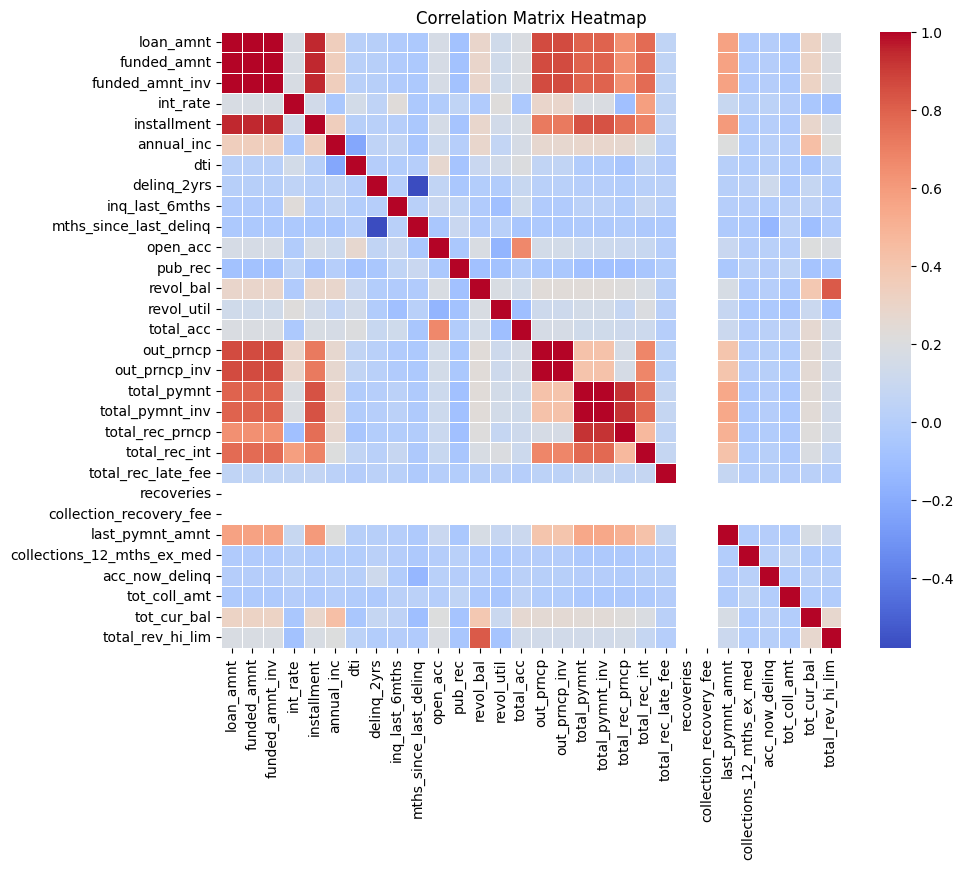

In [16]:
# Correlation matrix untuk melihat semua nilai korelasi pada setiap kolom-kolom numerik

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".1f", linewidths=0.5)

# Add a title
plt.title('Correlation Matrix Heatmap')

# Show the plot
plt.show()

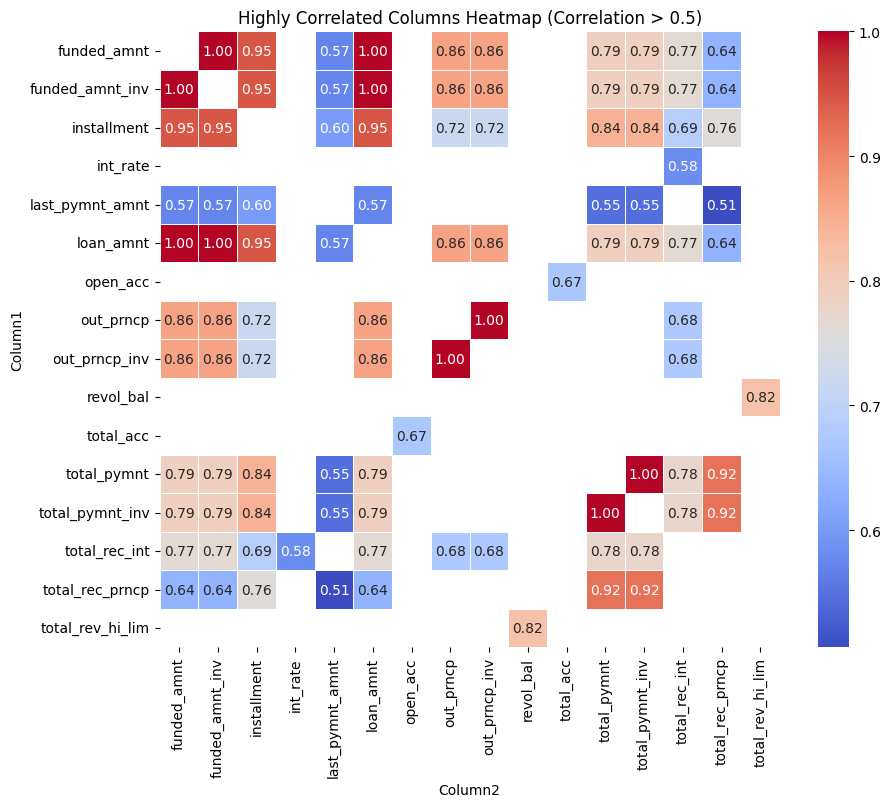

In [17]:
# Menghasilkan grafik heatmap korelasi yang berisi kolom-kolom dengan nilai korelasi lebih dari 0.5

def show_only_high_corr_value(df, threshold = 0.5):
  # Compute the correlation matrix
  corr_matrix = df.corr()

  # Filter columns based on correlation threshold (e.g., 0.5)
  high_corr_pairs = corr_matrix[corr_matrix > 0.5].stack().reset_index().query('level_0 != level_1')
  high_corr_pairs.columns = ['Column1', 'Column2', 'Correlation']
  high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'] > 0.5]

  # Create a pivot table for the heatmap
  heatmap_data = high_corr_pairs.pivot_table(index='Column1', columns='Column2', values='Correlation')

  # Set up the matplotlib figure
  plt.figure(figsize=(10, 8))

  # Create the heatmap
  sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

  # Add a title
  plt.title('Highly Correlated Columns Heatmap (Correlation > 0.5)')

  # Show the plot
  plt.show()

  return high_corr_pairs

high_corr_pairs_0_5 = show_only_high_corr_value(numeric_df, 0.6)

In [18]:
numeric_df_unique = numeric_df.nunique().sort_values(ascending=False)

# Mendapatkan name kolom-kolom yang berisi hanya satu nilai unik
half_unique_columns = []

for col in numeric_df_unique.index:
  if numeric_df_unique[col] > int(len(numeric_df)/2):
    half_unique_columns.append(col)
    print(f"{col}")

# Menghapus seluruh kolom yang hanya memiliki satu nilai unik
numeric_df = numeric_df.drop(columns=half_unique_columns)

tot_cur_bal
total_pymnt_inv
total_pymnt
total_rec_int
out_prncp_inv
out_prncp
total_rec_prncp


### Categorical Data

In [19]:
print(f'Jumlah baris: {categorical_df.shape[0]}')
print(f'Jumlah kolom: {categorical_df.shape[1]}')

Jumlah baris: 106883
Jumlah kolom: 19


Jumlah data setelah dilakukan penanganan missing value dan data unik sebanyak 106883 data dan 19 kolom (variabel).

# Second Data Preparation

Pengukuran outliers secara kuantitatif dapat dilakukan dengan teknik statistik seperti metode Z-score dan metode IQR (Interquartile Range).

1. Z-score Method
The Z-score method identifies outliers by calculating the number of standard deviations a data point is from the mean. Data points with a Z-score greater than a specified threshold (typically 3) are considered outliers.

2. IQR Method
The IQR method identifies outliers by calculating the interquartile range (IQR) and defining outliers as data points that fall below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR.

### Outliers handling

In [20]:
def calculate_outliers(df, z_threshold=3, iqr_multiplier=1.5):
    """
    Calculate outliers in a DataFrame using both Z-score and IQR methods.

    Parameters:
    - df: DataFrame with numerical data.
    - z_threshold: Z-score threshold for identifying outliers (default is 3).
    - iqr_multiplier: Multiplier for IQR method (default is 1.5).

    Returns:
    - DataFrame with the count of outliers for each method.
    """
    outliers_info = pd.DataFrame(index=df.columns, columns=['Z-score Outliers', 'IQR Outliers'])

    for column in df.columns:
        if np.issubdtype(df[column].dtype, np.number):
            # Z-score method
            z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
            z_outliers = z_scores > z_threshold
            outliers_info.at[column, 'Z-score Outliers'] = z_outliers.sum()

            # IQR method
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            iqr_lower_bound = Q1 - iqr_multiplier * IQR
            iqr_upper_bound = Q3 + iqr_multiplier * IQR
            iqr_outliers = (df[column] < iqr_lower_bound) | (df[column] > iqr_upper_bound)
            outliers_info.at[column, 'IQR Outliers'] = iqr_outliers.sum()

    return outliers_info

outliers_info = calculate_outliers(numeric_df)
print(outliers_info)

                           Z-score Outliers IQR Outliers
loan_amnt                                 0            0
funded_amnt                               0            0
funded_amnt_inv                           0            0
int_rate                                  0          649
installment                            1432         2708
annual_inc                             1065         4826
dti                                       0            0
delinq_2yrs                            1560         6184
inq_last_6mths                         2393         7245
mths_since_last_delinq                   44           46
open_acc                               1199         3217
pub_rec                                3116        16245
revol_bal                              1015         5335
revol_util                               12           11
total_acc                              1000         1988
total_rec_late_fee                     1470         2118
recoveries                     

In [21]:
def detect_and_plot_outliers(df):
    # Menghitung IQR dan mendeteksi outlier
    outliers = pd.DataFrame()
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_in_col = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers = pd.concat([outliers, outliers_in_col])

    # Membuat box plot untuk setiap kolom numerik
    df.select_dtypes(include=['float64', 'int64']).boxplot(figsize=(10, 8))
    plt.xticks(rotation=90)
    plt.show()

    return outliers

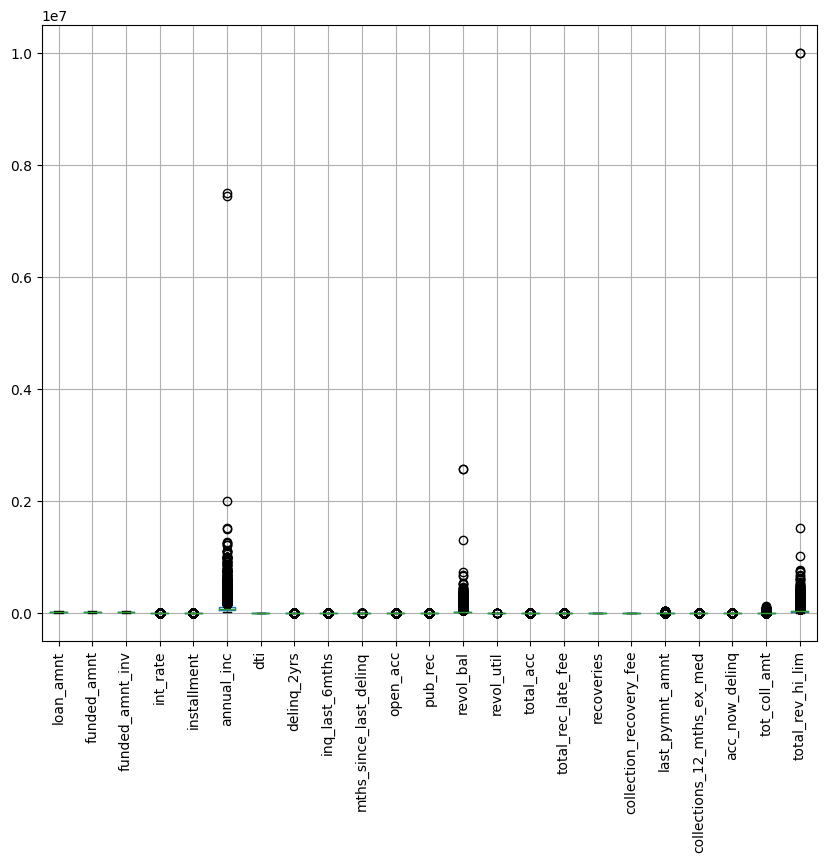

In [ ]:
# Deteksi dan plot outlier
outliers = detect_and_plot_outliers(numeric_df)

Terlihat bahwa terdapat indikasi outlier pada beberapa variabel, outlier paling jauh ada pada variabel total_rev_hi_lim dan annual_inc

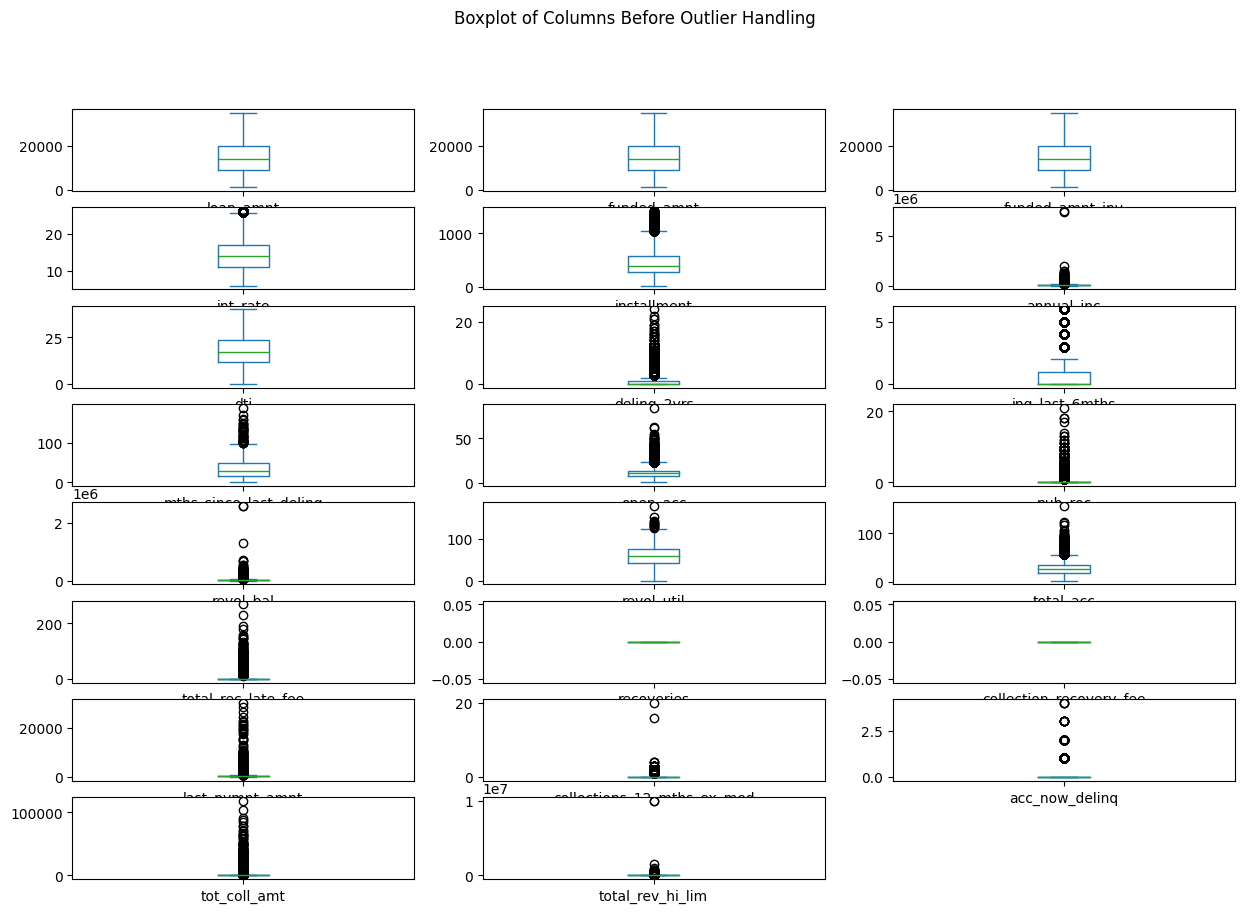

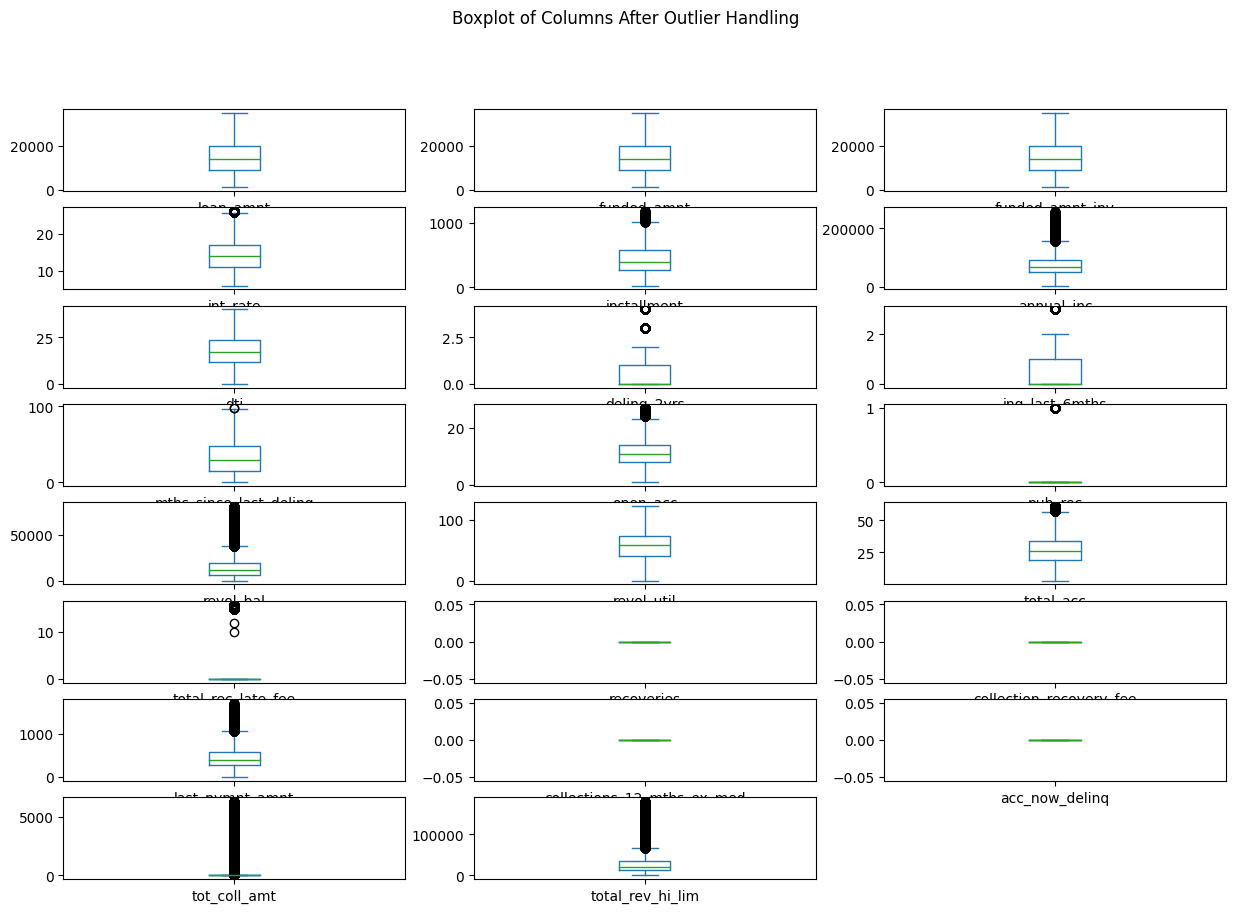

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

def handle_outliers(df, threshold=3, method='median'):
    """
    Handle outliers in a DataFrame by replacing them with the specified method.

    Parameters:
    - df: DataFrame containing the data.
    - threshold: Z-score threshold for identifying outliers (default is 3).
    - method: Method for replacing outliers ('median', 'mean', or 'winsorize').

    Returns:
    - DataFrame with outliers replaced according to the specified method.
    """
    # Display initial boxplot for all columns
    df.plot(kind='box', subplots=True, layout=(int(np.ceil(len(df.columns)/3)), 3), figsize=(15, 10))
    plt.suptitle('Boxplot of Columns Before Outlier Handling')
    plt.show()

    for column in df.columns:
        if np.issubdtype(df[column].dtype, np.number):
            z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())

            if method == 'median':
                replace_value = df[column].median()
            elif method == 'mean':
                replace_value = df[column].mean()
            elif method == 'winsorize':
                winsorized_values = winsorize(df[column], limits=[0.05, 0.05])
                df[column] = winsorized_values
                continue  # Move to the next column
            else:
                raise ValueError("Invalid method. Use 'median', 'mean', or 'winsorize'.")

            df.loc[z_scores > threshold, column] = replace_value

    # Display boxplot after outlier handling
    df.plot(kind='box', subplots=True, layout=(int(np.ceil(len(df.columns)/3)), 3), figsize=(15, 10))
    plt.suptitle('Boxplot of Columns After Outlier Handling')
    plt.show()

    return df

numeric_df = handle_outliers(numeric_df, threshold=3, method='median')

Penanganan outlier dilakukan dengan teknik mengisi median pada dataset

### Feature Engineering

##### Mengubah seluruh data string menjadi lowercase

In [23]:
# Convert all data in columns to lowercase
categorical_df = categorical_df.apply(lambda x: x.astype(str).str.lower())

##### Term atribute

Mengubah semua value di atribute term, dari value yang berisi kata month menjadi value yang hanya menampilkan integer jumlah bulannya saja

In [24]:
# Remove the non-numeric part and convert to integer
categorical_df['term'] = categorical_df['term'].str.extract('(\d+)').astype(int)

##### Zip Code atribute

Mengubah semua value di atribute zip code, dari value yang berisi karakter seperti  "xxx" menjadi value yang hanya menampilkan integer kode posnya saja

In [25]:
# Remove the non-numeric part and convert to integer
categorical_df['zip_code'] = categorical_df['zip_code'].str.extract('(\d+)').astype(int)

##### Mengubah loan status, jika loan status Current, Fully Paid, in grade periode, dan does not meet the credit policy dengan status: fully paid maka labelnya 1 (Good) dan jika selainnya maka labelnya 0 (Bad)

In [26]:
categorical_df['credit_status'] = categorical_df['loan_status'].apply(
    lambda x: 1 if x in ['current', 'fully paid', 'in grade period', 'does not meet the credit policy. status:fully paid'] else 0
)['label'] = categorical_df['loan_status'].apply(
    lambda x: 1 if x in ['current', 'fully paid', 'in grade period', 'does not meet the credit policy. status:fully paid'] else 0)
categorical_df.drop(columns=['loan_status'], inplace=True)

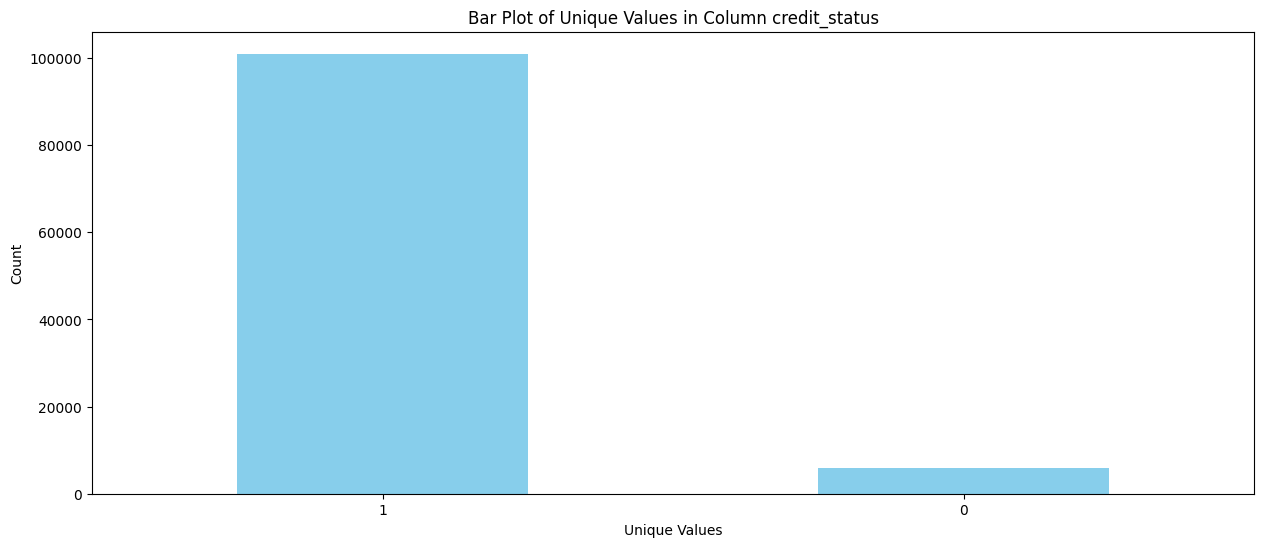

In [27]:
# Count occurrences of each unique value in the column
value_counts = categorical_df['credit_status'].value_counts()

# Plotting
plt.figure(figsize=(15, 6))
value_counts.plot(kind='bar', color='skyblue')
plt.title('Bar Plot of Unique Values in Column credit_status')
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Kode 1 menunjukkan kelas good sedangkan kode 0 menunjukkan kelas bad, berdasarkan bar chart yang telah dibuat dapat dilihat bahwa terdapat ketimpangan yang sangat jauh antara kelas good dengan bad nya

##### Earliest Credit Line, Last Payment Date and Last Credit Pull Date atributes

Mengekstrak tanggal dengan format bulan dan tahun

In [28]:
# Convert date strings to datetime objects
categorical_df['earliest_cr_line'] = pd.to_datetime(categorical_df['earliest_cr_line'], format='%b-%y').dt.strftime('%m-%y')
categorical_df['last_pymnt_d'] = pd.to_datetime(categorical_df['last_pymnt_d'], format='%b-%y').dt.strftime('%m-%y')
categorical_df['last_credit_pull_d'] = pd.to_datetime(categorical_df['last_credit_pull_d'], format='%b-%y').dt.strftime('%m-%y')

##### emp_length

In [29]:
def process_emp_length(emp_length):
    if '10+' in emp_length:
        return 11
    elif '<1' in emp_length:
        return 0
    else:
        # Extract digits
        digits = ''.join(filter(str.isdigit, emp_length))
        # Check if digits is not empty
        return int(digits) if digits else 0

categorical_df['emp_length'] = categorical_df['emp_length'].apply(process_emp_length)

In [30]:
def categorize_emp_length(value):
    if value >= 10:
        return ">10"
    else:
        return "<10"

# Categorize the processed values
categorical_df['emp_length'] = categorical_df['emp_length'].apply(categorize_emp_length)

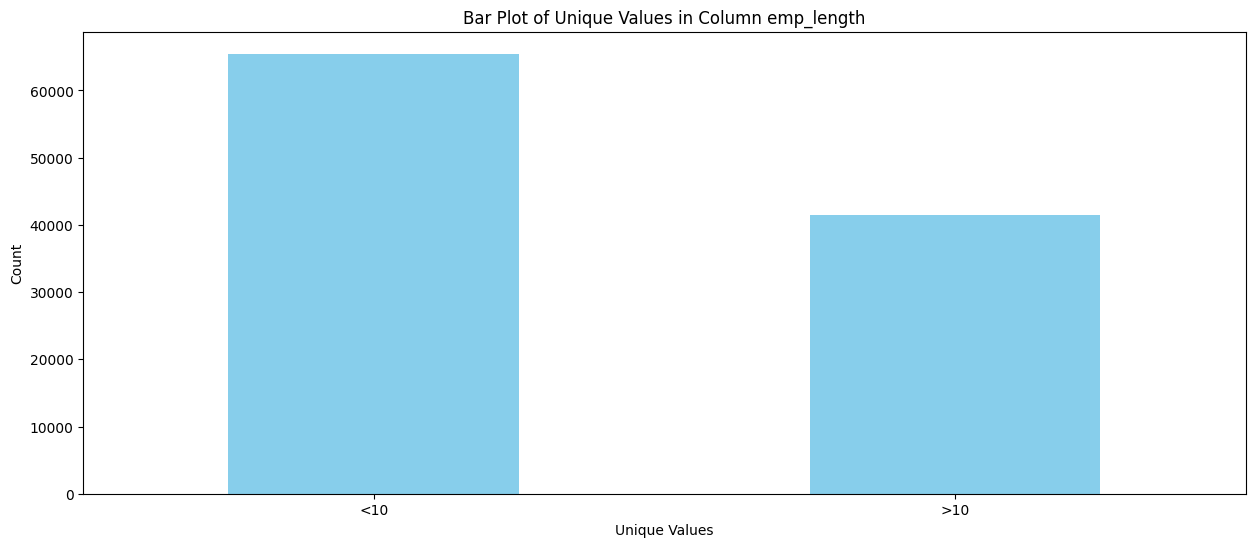

In [31]:
# Count occurrences of each unique value in the column
value_counts = categorical_df['emp_length'].value_counts()

# Plotting
plt.figure(figsize=(15, 6))
value_counts.plot(kind='bar', color='skyblue')
plt.title('Bar Plot of Unique Values in Column emp_length')
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

##### Mengubah data string tanggal menjadi datetime

In [32]:
# Convert to datetime format
categorical_df['last_pymnt_d'] = pd.to_datetime(categorical_df['last_pymnt_d'], format='%m-%y')
categorical_df['last_credit_pull_d'] = pd.to_datetime(categorical_df['last_credit_pull_d'], format='%m-%y')
categorical_df['earliest_cr_line'] = pd.to_datetime(categorical_df['earliest_cr_line'], format='%m-%y')

##### Mengekstrak fitur penilaian kredit dari fitur last creadit pull data dengan last payment date

* Penilaian 0 adalah penilaian dilakukan tepat setelah pembayaran kredit terakhir
* Penilaian 1-9 adalah penilaian dilakukan setelah 1 sampai 9 bulan setelah pembayaran kredit terakhir
* Penilaian 10+ adalah penilaian dilakukan setelah 10 atau lebih bulan setelah pembayaran kredit terakhir

In [33]:
# Perform subtraction and convert to months
categorical_df['credit_assessment'] = ((categorical_df['last_credit_pull_d'] - categorical_df['last_pymnt_d']) / pd.Timedelta(days=30.44)).astype(int)

def categorize_emp_length(value):
    if value > 10:
        return "10+"
    elif value > 0:
        return "1-9"
    else:
        return "0"

# Categorize the processed values
categorical_df['credit_assessment'] = categorical_df['credit_assessment'].apply(categorize_emp_length)

categorical_df.drop(columns=['last_pymnt_d', 'last_credit_pull_d'], inplace=True)

##### Mengelompokkan setiap address state ke dalam region mereka masing-masing, seperti west coast, east coast, midwest, south

In [34]:
region_mapping = {
    'West Coast': ['ca', 'or', 'wa', 'ak', 'co', 'nv'],
    'East Coast': ['nc', 'va', 'ct', 'fl', 'pa', 'nj', 'ky', 'sc', 'la', 'ma', 'ny', 'md', 'nh', 'ri'],
    'Midwest': ['il', 'mn', 'oh', 'wi', 'ks', 'mi'],
    'South': ['tx', 'az', 'ut', 'ga']
}

categorical_df['region'] = categorical_df['addr_state'].apply(lambda x: next((region for region, states in region_mapping.items() if x in states), 'Other'))

categorical_df.drop(columns=['addr_state'], inplace=True)

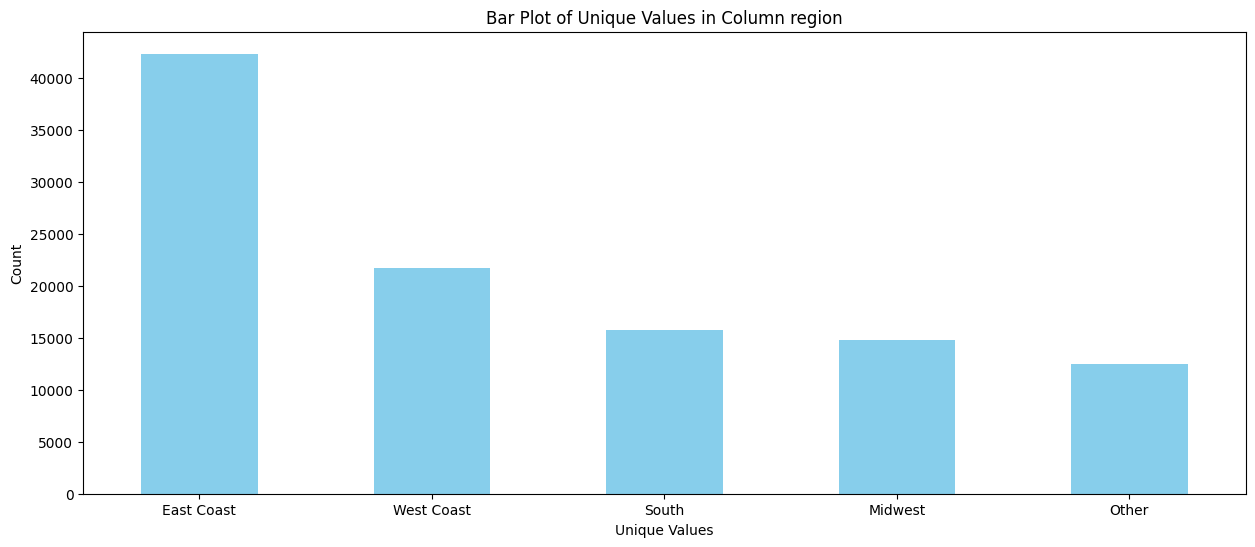

In [35]:
# Count occurrences of each unique value in the column
value_counts = categorical_df['region'].value_counts()

# Plotting
plt.figure(figsize=(15, 6))
value_counts.plot(kind='bar', color='skyblue')
plt.title('Bar Plot of Unique Values in Column region')
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [36]:
# Convert all data in columns to lowercase
categorical_df = categorical_df.apply(lambda x: x.astype(str).str.lower())

In [37]:
categorical_df_unique = categorical_df.nunique().sort_values(ascending=False)

# Mendapatkan name kolom-kolom yang berisi hanya satu nilai unik
half_unique_columns = []

for col in categorical_df_unique.index:
  if categorical_df_unique[col] > int(len(categorical_df)/2):
    half_unique_columns.append(col)
    print(f"{col}")

# Menghapus seluruh kolom yang hanya memiliki satu nilai unik
categorical_df = categorical_df.drop(columns=half_unique_columns)

In [82]:
numeric_df.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'open_acc', 'revol_bal', 'revol_util',
       'total_acc', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt',
       'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt',
       'total_rev_hi_lim'],
      dtype='object')

### Univariate Analysis

In [38]:
def format_number(num):
    if abs(num) >= 1e7:
        return f"{num:.1e}"
    else:
        return f"{num:.1f}"

def univariate_analysis(df, column_name):
    # Cek apakah nama kolom ada di dalam dataset
    if column_name not in df.columns:
        return "Column not found in the DataFrame"

    # Hanya menerima kolom dengan nilai numerik
    if not pd.api.types.is_numeric_dtype(df[column_name]):
        return "Only numeric data is allowed"

    mean = df[column_name].mean()
    median = df[column_name].median()
    mode = df[column_name].mode()[0] if not df[column_name].mode().empty else None
    variance = df[column_name].var()
    std_dev = df[column_name].std()

    formatted_stats = {
        'Mean': format_number(mean),
        'Median': format_number(median),
        'Mode': format_number(mode) if mode is not None else None,
        'Variance': format_number(variance),
        'Standard Deviation': format_number(std_dev)
    }

    stats_table = pd.DataFrame({
        'Statistic': list(formatted_stats.keys()),
        'Value': list(formatted_stats.values())
    })

    return stats_table

print(univariate_analysis(numeric_df, 'int_rate'))

            Statistic Value
0                Mean  14.2
1              Median  14.0
2                Mode  13.0
3            Variance  18.0
4  Standard Deviation   4.2


### Bivariate Analysis

In [39]:
def bivariate_analysis(df, col1, col2):
    # Check if both columns exist in the DataFrame
    if col1 not in df.columns or col2 not in df.columns:
        return "One or both columns not found in the DataFrame"

    # Check if both columns are numerical
    if not pd.api.types.is_numeric_dtype(df[col1]) or not pd.api.types.is_numeric_dtype(df[col2]):
        return "Both columns must be numeric"

    # Calculate correlation
    correlation = df[col1].corr(df[col2])

    # Determine the status of correlation
    if correlation == 1.0 or correlation == -1.0:
        status = "Absolute Correlation"
    elif abs(correlation) > 0.7:
        status = "Strong Correlation"
    elif abs(correlation) > 0.3:
        status = "Moderate Correlation"
    else:
        status = "Low Correlation"

    # Display the correlation and status
    result = pd.DataFrame({
        'Column 1': [col1],
        'Column 2': [col2],
        'Correlation': [correlation],
        'Status': [status]
    })

    return result

print(bivariate_analysis(numeric_df, 'int_rate', 'delinq_2yrs'))

   Column 1     Column 2  Correlation           Status
0  int_rate  delinq_2yrs     0.045801  Low Correlation


### Multivariate Analysis

In [60]:
def multivariate_mean(df):
    # Select only numeric columns
    numeric_cols = df.select_dtypes(include='number')

    # Check if there are any numeric columns
    if numeric_cols.empty:
        return "No numeric columns found in the DataFrame"

    # Calculate the mean for each numeric column
    mean_values = numeric_cols.mean()

    # Create a DataFrame to display the multivariate mean
    result = pd.DataFrame({
        'Column': mean_values.index,
        'Mean': mean_values.values
    })

    return result

print(multivariate_mean(numeric_df))

                        Column          Mean
0                    loan_amnt  1.505759e+04
1                  funded_amnt  1.505759e+04
2              funded_amnt_inv  1.505186e+04
3                     int_rate -3.196289e-16
4                  installment  4.370594e+02
5                   annual_inc  7.583819e+04
6                          dti  1.775735e+01
7                  delinq_2yrs -2.712325e-17
8               inq_last_6mths  3.018126e-17
9       mths_since_last_delinq  3.308082e+01
10                    open_acc  2.085765e-16
11                   revol_bal  1.419792e+04
12                  revol_util  5.714268e+01
13                   total_acc -1.847273e-16
14          total_rec_late_fee -3.958798e-17
15                  recoveries  0.000000e+00
16     collection_recovery_fee  0.000000e+00
17             last_pymnt_amnt  4.509577e+02
18  collections_12_mths_ex_med  0.000000e+00
19              acc_now_delinq  0.000000e+00
20                tot_coll_amt  1.313634e+02
21        

In [85]:
categorical_df.columns

Index(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'pymnt_plan',
       'purpose', 'title', 'zip_code', 'earliest_cr_line',
       'initial_list_status', 'next_pymnt_d', 'credit_status',
       'credit_assessment', 'region'],
      dtype='object')

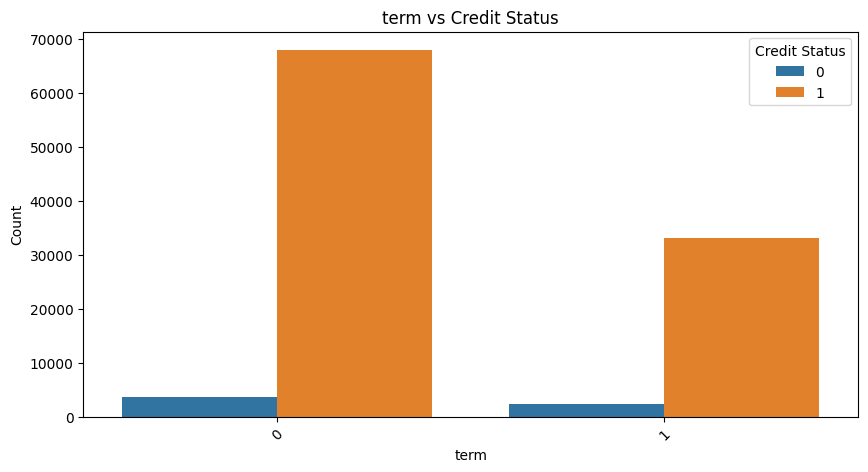

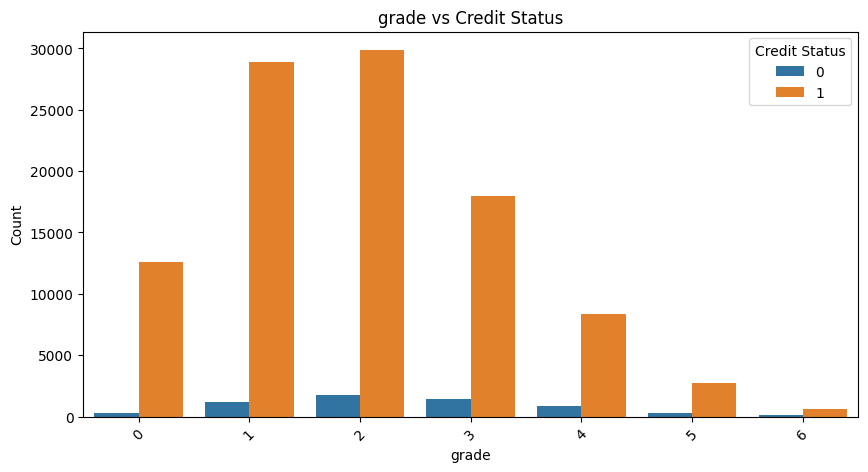

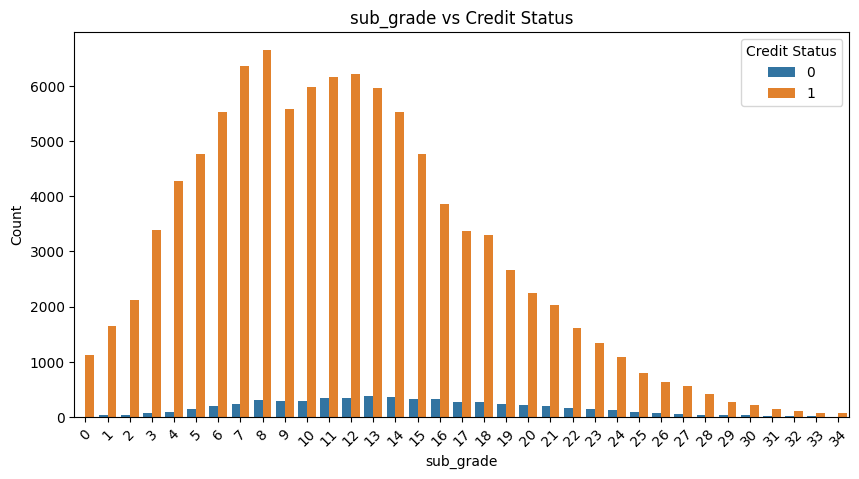

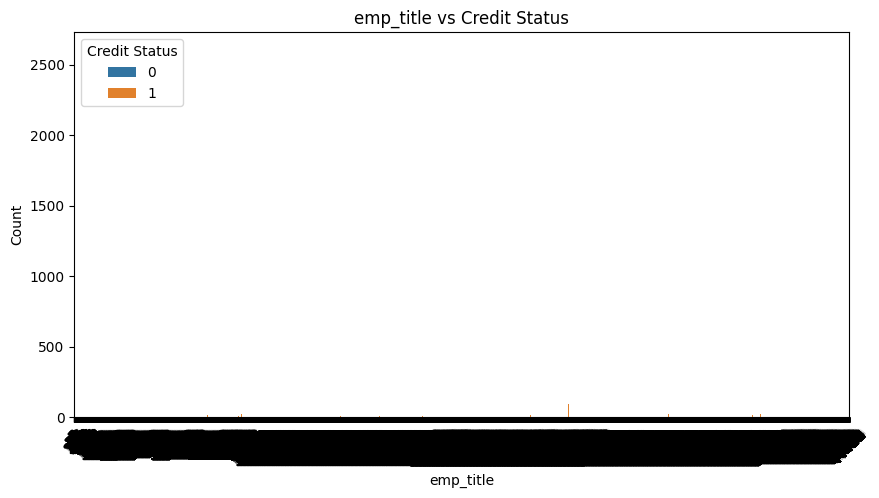

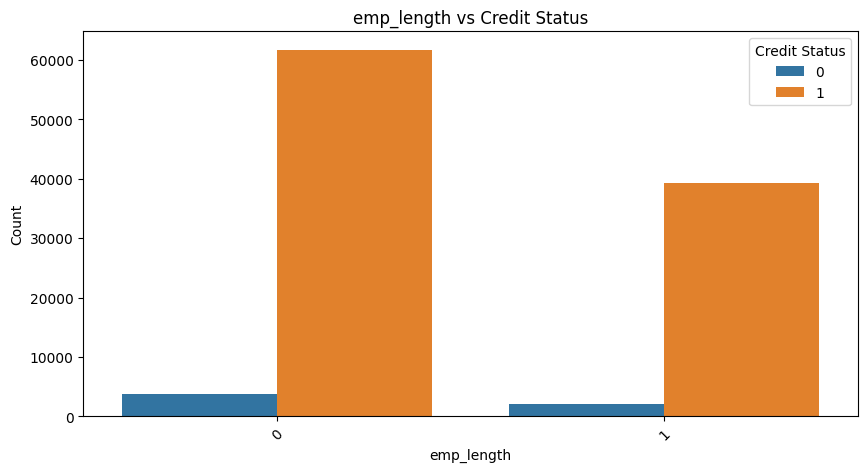

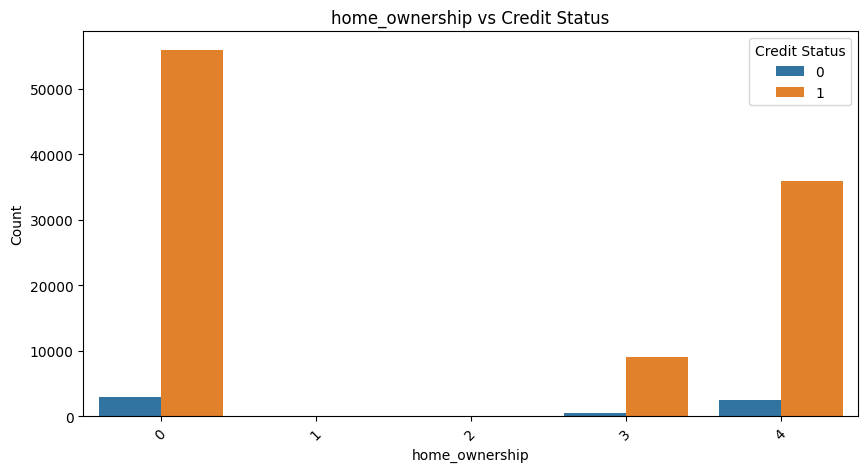

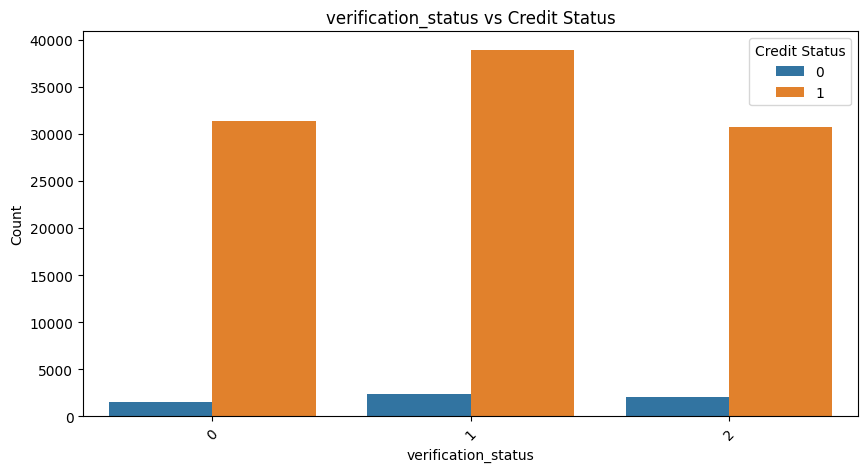

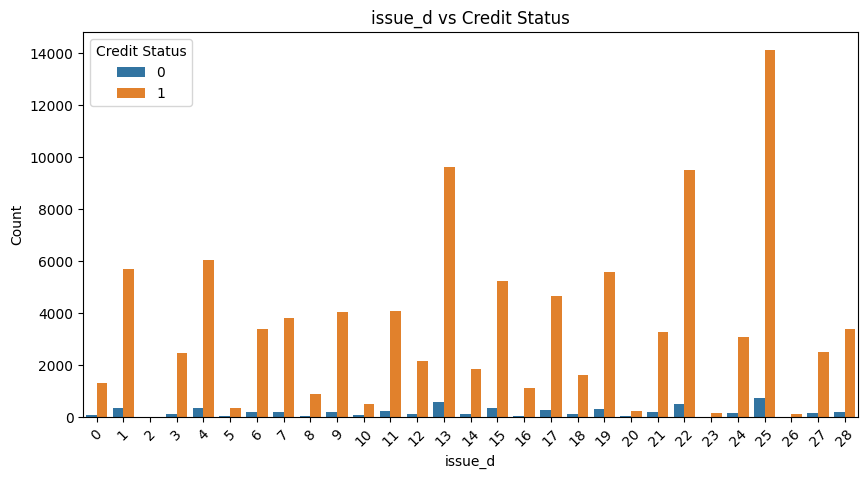

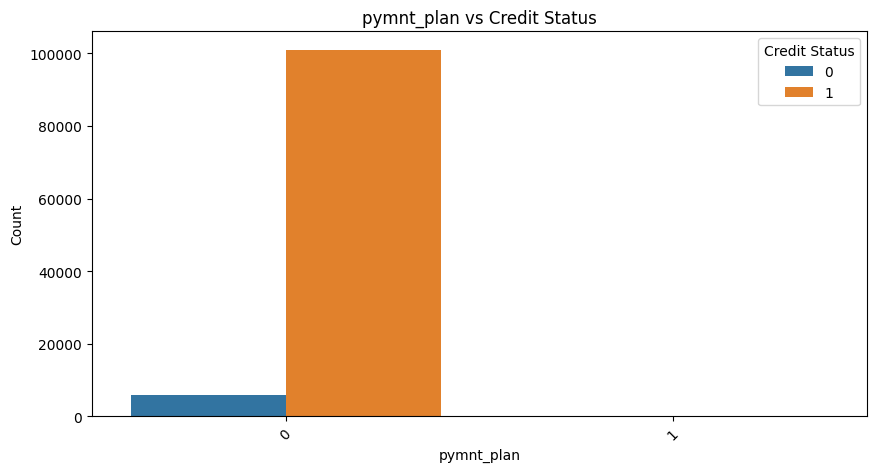

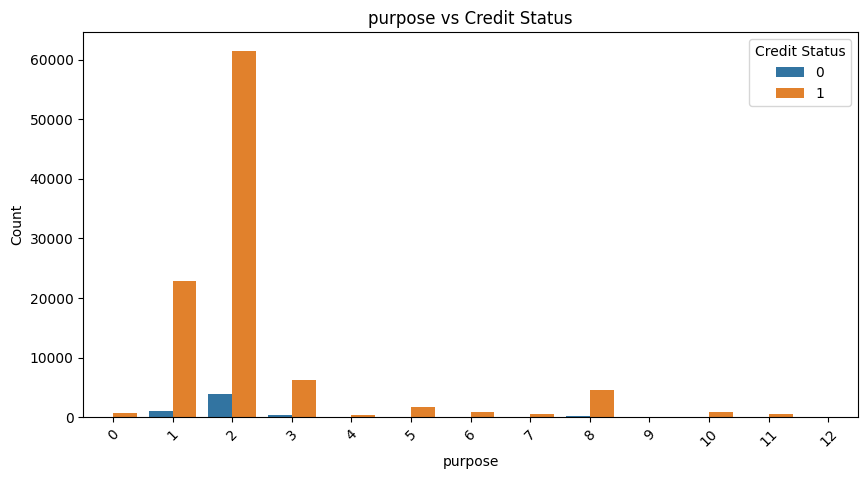

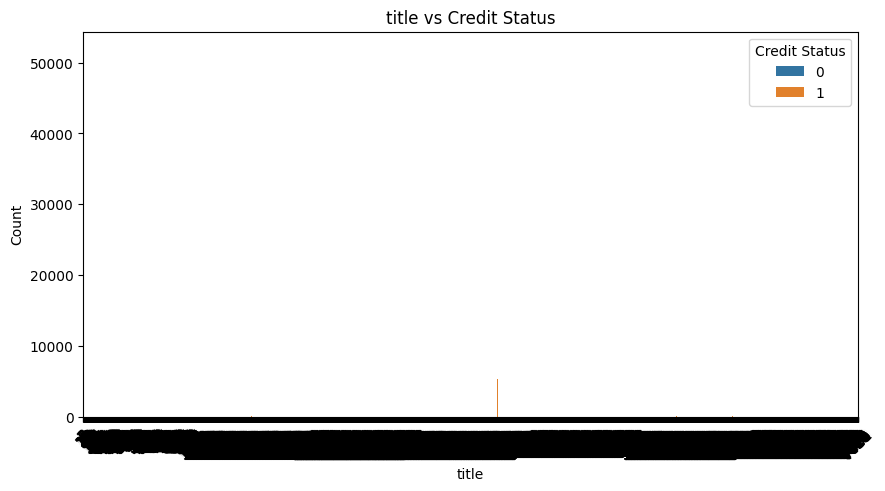

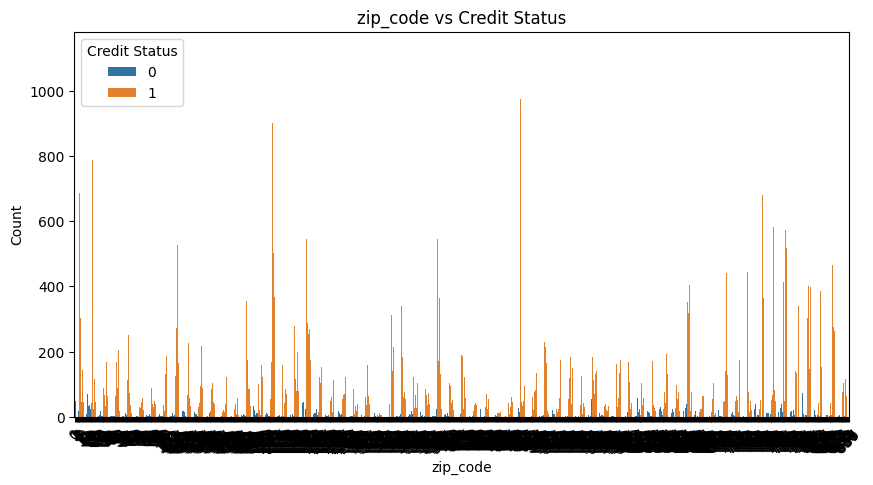

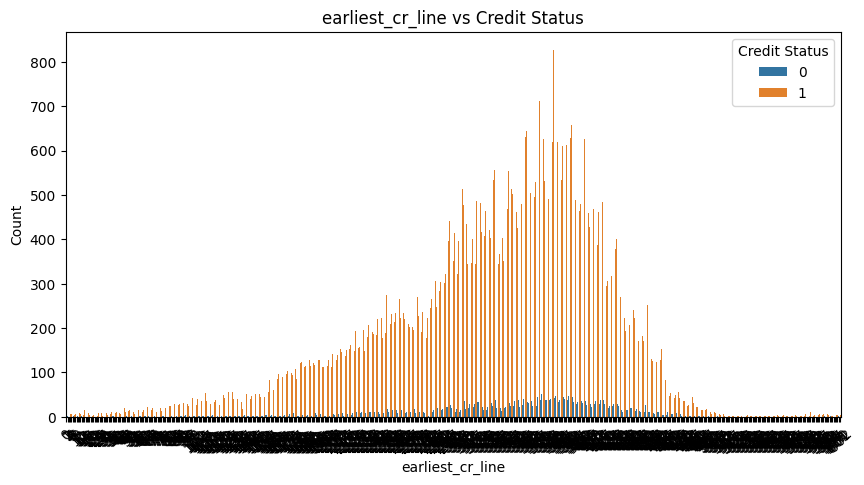

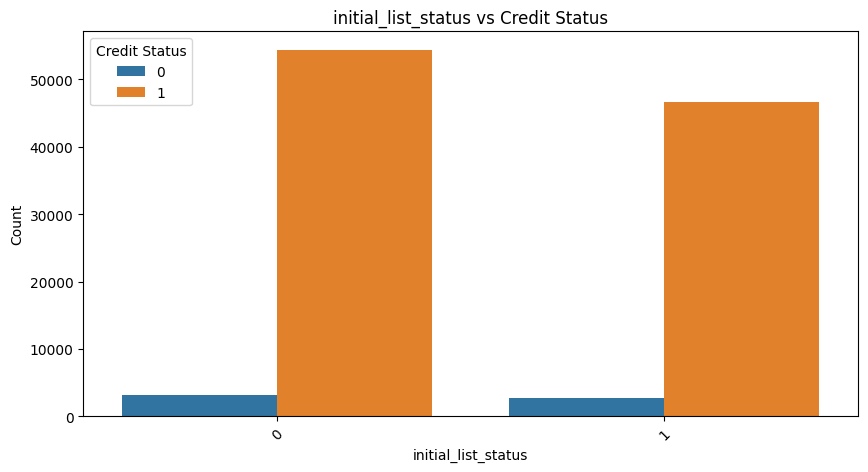

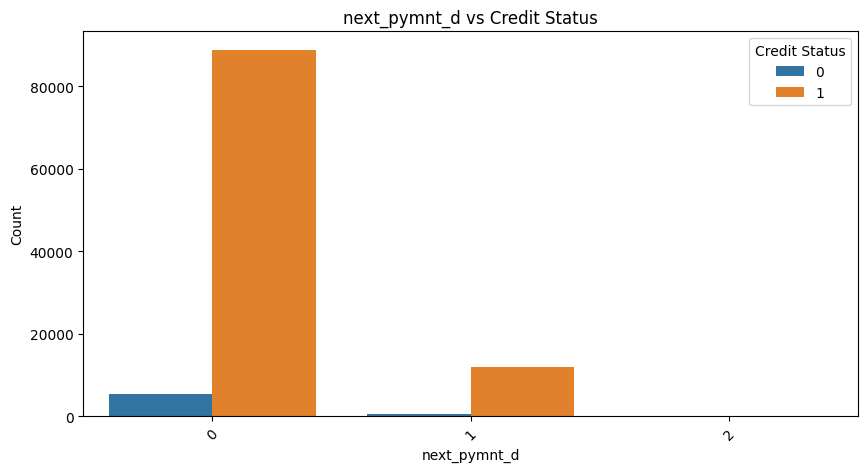

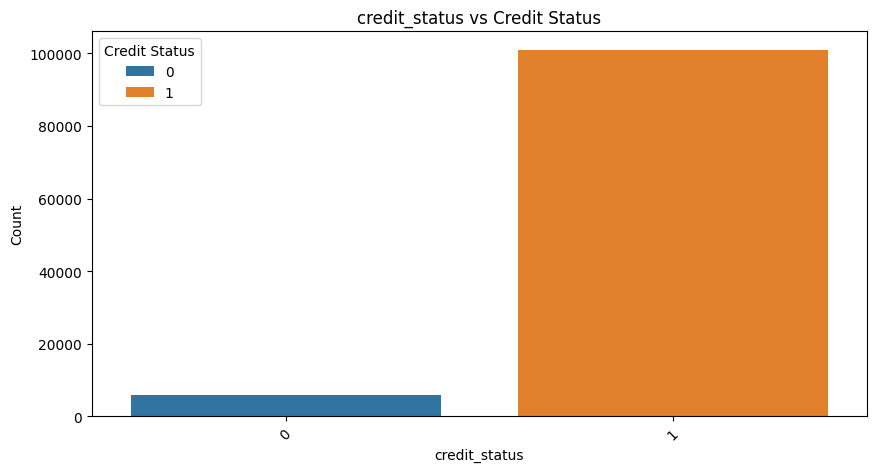

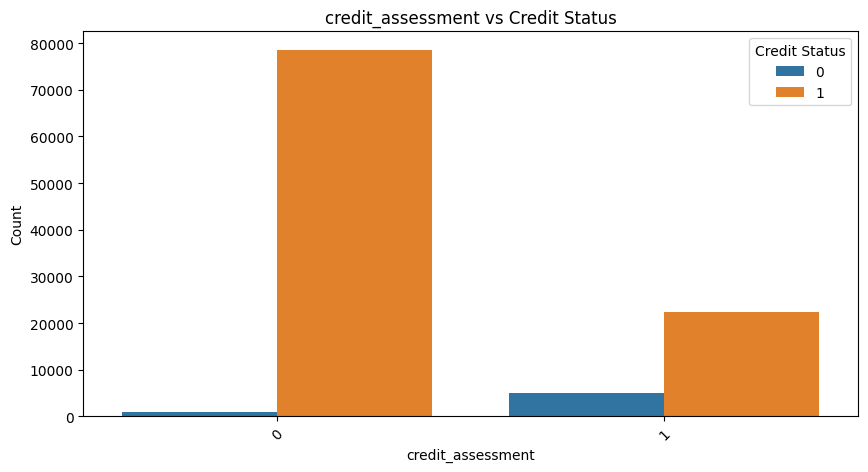

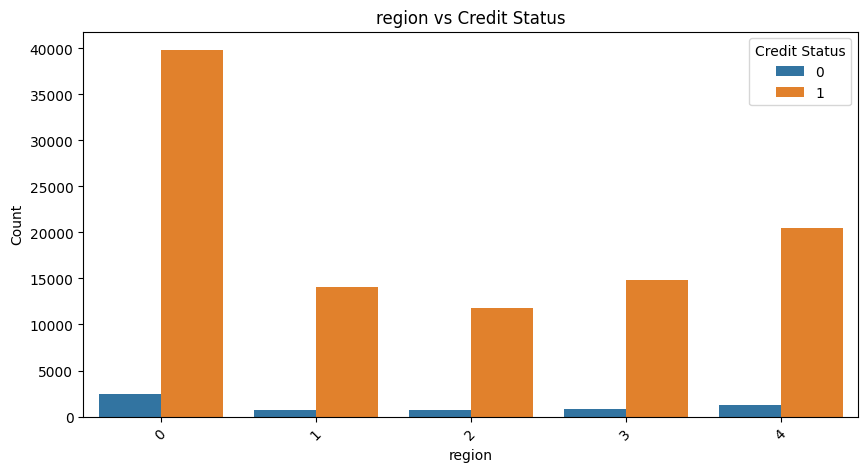

In [86]:
# Hubungan antara variabel kategorikal dan kolom target
for col in categorical_df:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, hue='credit_status', data=categorical_df)
    plt.title(f'{col} vs Credit Status')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Credit Status')
    plt.show()

### Encoding

In [40]:
label_enc_columns = categorical_df.columns
label_enc = LabelEncoder()
for col in label_enc_columns:
    categorical_df[col] = label_enc.fit_transform(categorical_df[col])

### Normalization

In [41]:
numeric_df = numeric_df.drop(columns=["pub_rec"])

In [42]:
# Standard Scaler
standard_scaler = StandardScaler()
standard_columns = ['total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'int_rate', 'open_acc', 'total_acc', 'delinq_2yrs', 'inq_last_6mths']
# standard_columns = ['out_prncp', 'out_prncp_inv', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'int_rate', 'open_acc', 'total_acc', 'delinq_2yrs', 'inq_last_6mths']
numeric_df[standard_columns] = standard_scaler.fit_transform(numeric_df[standard_columns])

### Combine numeric and categorical dataframe

In [43]:
# Join on index
df_combined = numeric_df.join(categorical_df, how='outer')

Menggabungkan variabel dengan tipe data kategorik dengan numerik setelah dilakukan encoding dan normalisasi dengan standard scaler. Setelah itu dapat dilakukan proses cek korelasi antar variabel.

# Correlation and PCA

### Correlation

In [44]:
# Compute the correlation matrix
correlation_matrix = df_combined.corr()

# Set a correlation threshold
threshold = 0.8

# Identify pairs with high correlation
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

# Count the pairs
num_high_corr_pairs = len(high_corr_pairs)

# Output results
print(f"Number of pairs with high correlation: {num_high_corr_pairs}")
print(f"Pairs of predictors with correlation above {threshold}:\n")

high_corr_pairs

Number of pairs with high correlation: 13
Pairs of predictors with correlation above 0.8:



[('funded_amnt', 'loan_amnt', 1.0),
 ('funded_amnt_inv', 'loan_amnt', 0.9999962248110299),
 ('funded_amnt_inv', 'funded_amnt', 0.9999962248110299),
 ('installment', 'loan_amnt', 0.9037941308765318),
 ('installment', 'funded_amnt', 0.9037941308765318),
 ('installment', 'funded_amnt_inv', 0.9037509765178027),
 ('last_pymnt_amnt', 'loan_amnt', 0.9311141180036125),
 ('last_pymnt_amnt', 'funded_amnt', 0.9311141180036125),
 ('last_pymnt_amnt', 'funded_amnt_inv', 0.9311056700188775),
 ('last_pymnt_amnt', 'installment', 0.9034739665587556),
 ('grade', 'int_rate', 0.9598290114459157),
 ('sub_grade', 'int_rate', 0.9840410283618658),
 ('sub_grade', 'grade', 0.9758904431514243)]

Terdapat korelasi yang sangat kuat antar variabel independen dengan variabel indepen lainnya, hal tersebut memunculkan multikolinearitas pada dataset. Beberapa variabel independen yang memiliki korelasi yang sangat kuat antara lain yaitu: (funded_amnt dengan loan_amnt),(funded_amnt_inv dengan loan_amnt),(funded_amnt_inv dengan funded_amnt), (installment dengan loan_amnt),  (installment dengan funded_amnt), (installment dengan funded_amnt_inv),(last_pymnt_amnt dengan loan_amnt), (last_pymnt_amnt dengan funded_amnt),(last_pymnt_amnt dengan funded_amnt_inv), (last_pymnt_amnt dengan installment),(grade dengan int_rate), (sub_grade dengan int_rate), dan (sub_grade dengan grade)

In [45]:
# Step 2: Compute the correlation matrix
correlation_matrix = df_combined.corr()

# Step 3: Select the row corresponding to the dependent variable
dependent_variable = 'credit_status'
correlations_with_dependent = correlation_matrix[dependent_variable]

# Step 4: Set a correlation threshold and identify strong correlations
threshold = 0.5
# strong_correlations = correlations_with_dependent[abs(correlations_with_dependent) > threshold].drop(labels=[dependent_variable])
strong_correlations = correlations_with_dependent[correlations_with_dependent > threshold].drop(labels=[dependent_variable])

# Step 5: Count the number of strongly correlated independent variables
num_strong_correlations = len(strong_correlations)

# Output results
print(f"Number of independent variables with strong correlation with {dependent_variable}: {num_strong_correlations}")
print(f"Independent variables with correlation above {threshold}:\n", strong_correlations)

Number of independent variables with strong correlation with credit_status: 0
Independent variables with correlation above 0.5:
 Series([], Name: credit_status, dtype: float64)


Tidak ada variabel independen yang berkorelasi kuat dengan variabel dependennya atau kelasnya

### PCA

Model logistik regression sangat sensitif terhadap multikolinearitas pada data. Multikolinearitas mengganggu estimasi koefisien dalam regresi logistik karena adanya hubungan linear yang kuat antara dua atau lebih variabel independen.  Sehingga perlu adanya penanganan untuk menangani data yang multikolinearitas. Pada project ini dipililh teknik PCA (Pricipal Component Analysis) dengan cara mereduksi data untuk menangani permasalahan tersebut.

In [46]:
# Separate the independent and dependent variables
dependent_variable = 'credit_status'
X = df_combined.drop(columns=[dependent_variable])  # Independent variables
y = df_combined[dependent_variable]  # Dependent variable

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X)

# Transform the data
# The transformed data is already stored in X_pca

# Output the explained variance ratio of each principal component
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio of Each Principal Component:\n", explained_variance_ratio)

# Optionally, create a DataFrame for the PCA-transformed data
# This step is not necessary, but it may be useful for further analysis
pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
df_pca = pd.DataFrame(X_pca, columns=pca_columns)

Explained Variance Ratio of Each Principal Component:
 [6.57199301e-01 1.93054095e-01 6.70519511e-02 6.05374635e-02
 2.14089615e-02 5.87721333e-04 1.21373292e-04 2.86869941e-05
 5.06282996e-06 2.69489916e-06 2.15418848e-06 1.92829503e-07
 1.46176006e-07 1.26937926e-07 2.76727671e-08 2.23266636e-08
 1.38306037e-08 1.40101258e-09 8.93961019e-10 5.05893872e-10
 4.13454961e-10 4.11491829e-10 3.67087669e-10 2.37963998e-10
 2.09091900e-10 1.46964297e-10 9.80170769e-11 9.23218754e-11
 8.08345263e-11 4.16764495e-11 3.15622358e-11 2.13716803e-11
 1.10345905e-11 1.16785016e-14 3.30228910e-33 3.30228910e-33
 3.30228910e-33 3.30228910e-33 2.44776900e-33]


Nilai-nilai dari hasil reduksi dimensi dengan teknik PCA merupakan representatif untuk dataset tersebut.

In [47]:
# Join on index
df_after_pca = df_pca.join(y, how='outer')

# Third Data Preparation

### Data Splitting

In [48]:
# Drop the credit_status column for X and keep it for y
X_log = df_after_pca.drop('credit_status', axis=1)
y_log = df_after_pca['credit_status']

# Step 1: Split the data into training (80%) and testing (20%) sets
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log, test_size=0.2, random_state=42)

# Step 2: Split the training set into training (80% of the 80%) and validation (20% of the 80%) sets
X_train_log, X_val_log, y_train_log, y_val_log = train_test_split(X_train_log, y_train_log, test_size=0.25, random_state=42)
# 0.25 x 0.8 = 0.2, which means 20% of the original data will be the validation set

# Output the shapes of the resulting splits
print("Training set shape:", X_train_log.shape, y_train_log.shape)
print("Validation set shape:", X_val_log.shape, y_val_log.shape)
print("Testing set shape:", X_test_log.shape, y_test_log.shape)

Training set shape: (64129, 39) (64129,)
Validation set shape: (21377, 39) (21377,)
Testing set shape: (21377, 39) (21377,)


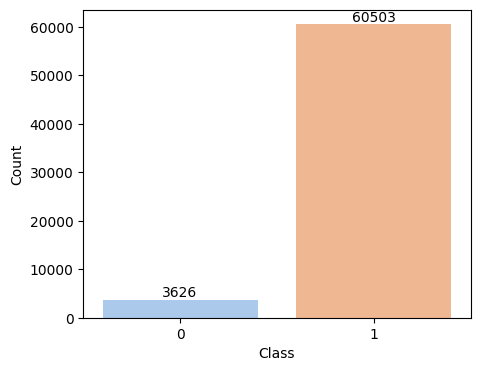

In [49]:
# Untuk Logistic Regression
# Menghitung jumlah setiap nilai dalam y_train
value_counts_train_log = y_train_log.value_counts()

# Membuat grafik menggunakan Seaborn
plt.figure(figsize=(5, 4))
sns.barplot(x=value_counts_train_log.index, y=value_counts_train_log.values, palette='pastel')
plt.xlabel('Class')
plt.ylabel('Count')

# Menambahkan jumlah nilai setiap kelas pada grafik
for i in range(len(value_counts_train_log)):
    plt.text(i, value_counts_train_log[i], str(value_counts_train_log[i]), ha='center', va='bottom')

In [50]:
# Drop the credit_status column for X and keep it for y
X = df_combined.drop('credit_status', axis=1)
y = df_combined['credit_status']

# Step 1: Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Split the training set into training (80% of the 80%) and validation (20% of the 80%) sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
# 0.25 x 0.8 = 0.2, which means 20% of the original data will be the validation set

# Output the shapes of the resulting splits
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (64129, 39) (64129,)
Validation set shape: (21377, 39) (21377,)
Testing set shape: (21377, 39) (21377,)


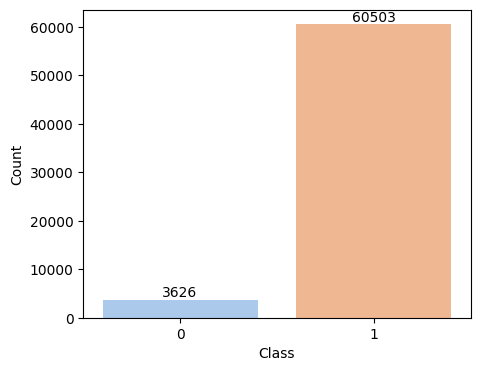

In [51]:
# Menghitung jumlah setiap nilai dalam y_train
value_counts_train = y_train.value_counts()

# Membuat grafik menggunakan Seaborn
plt.figure(figsize=(5, 4))
sns.barplot(x=value_counts_train.index, y=value_counts_train.values, palette='pastel')
plt.xlabel('Class')
plt.ylabel('Count')

# Menambahkan jumlah nilai setiap kelas pada grafik
for i in range(len(value_counts_train)):
    plt.text(i, value_counts_train[i], str(value_counts_train[i]), ha='center', va='bottom')

### Oversampling

##### Oversampling untuk Logistic Regression

Oversampling untuk logistic regression menggunakan data yang telah dilakukan teknik PCA, dan hanya menggunakan data training saja

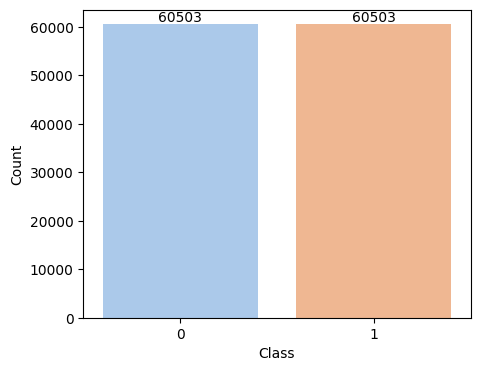

In [52]:
# Oversampling menggunakan SMOTE
X_train_log_resampled, y_train_log_resampled = smote.fit_resample(X_train_log, y_train_log)

# Menghitung jumlah setiap nilai dalam y_train_resampled
value_counts_train_res_log = y_train_log_resampled.value_counts()

# Membuat grafik menggunakan Seaborn
plt.figure(figsize=(5, 4))
sns.barplot(x=value_counts_train_res_log.index, y=value_counts_train_res_log.values, palette='pastel')
plt.xlabel('Class')
plt.ylabel('Count')

# Menambahkan jumlah nilai setiap kelas pada grafik
for i in range(len(value_counts_train_res_log)):
    plt.text(i, value_counts_train_res_log[i], str(value_counts_train_res_log[i]), ha='center', va='bottom')

##### Oversampling untuk Model Random Forest dan XGBoost

Oversampling untuk model Random Forest dan XGBoost menggunakan data yang tidak dilakukan teknik PCA dikarenakan model ensemble learning dapat menangani masalah multikolinearitas dengan baik. Oversampling hanya menggunakan data training saja

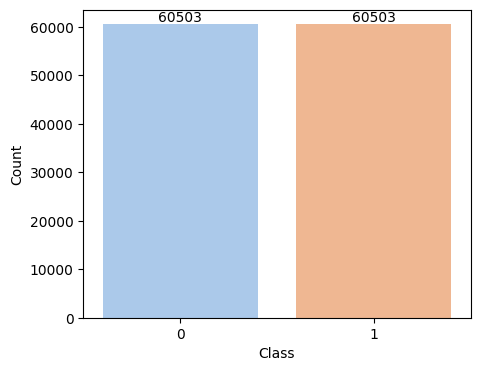

In [53]:
# Oversampling menggunakan SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Menghitung jumlah setiap nilai dalam y_train_resampled
value_counts_train_res = y_train_resampled.value_counts()

# Membuat grafik menggunakan Seaborn
plt.figure(figsize=(5, 4))
sns.barplot(x=value_counts_train_res.index, y=value_counts_train_res.values, palette='pastel')
plt.xlabel('Class')
plt.ylabel('Count')

# Menambahkan jumlah nilai setiap kelas pada grafik
for i in range(len(value_counts_train_res)):
    plt.text(i, value_counts_train_res[i], str(value_counts_train_res[i]), ha='center', va='bottom')

# Model Selection

### Hyperparameter Tuning + Cross validation

In [54]:
random_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'solver': ['liblinear', 'lbfgs', 'saga'],  # Solver algorithm
    'max_iter': [100, 200, 300]  # Maximum number of iterations
}

random_grid_rf = {'n_estimators': [20,50,100,150], # Number of trees in the random forest
    'max_depth': [int(x) for x in np.linspace(10, 120, num = 12)], # Maximum number of levels allowed in each decision tree
    'min_samples_split': [6, 10, 15], # Minimum sample number to split a node
    'min_samples_leaf': [3, 4, 6], # Minimum sample number that can be stored in a leaf node
    'bootstrap': [True, False] # Method used to sample data points
}

random_grid_xgb = {'max_depth': [2, 3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': np.arange(0.1, 1.0, 0.1),
    'colsample_bytree': np.arange(0.5, 1.0, 0.1),
    'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
    'n_estimators': [50, 100, 250, 500]
}

# Create a Logistic Regression model
lr_model = LogisticRegression(random_state=42)

# Create RandomizedSearchCV
lr_grid = GridSearchCV(
    estimator=lr_model,
    param_grid=random_grid_lr,
    cv=5,
    scoring='accuracy',
    verbose=1
)

# Randomized search on hyper parameters.
rf_random = RandomizedSearchCV(
    estimator = RandomForestClassifier(),
    param_distributions = random_grid_rf,
    n_iter = 100,
    cv = 5,
    verbose = 2,
    random_state = 35,
    n_jobs = -1
)

xgb_random = RandomizedSearchCV(
    estimator = xgb.XGBClassifier(),
    param_distributions = random_grid_xgb,
    scoring = 'accuracy',
    n_iter = 25,
    n_jobs = 4,
    verbose = 1,
    error_score = 'raise'
)

In [55]:
models = [
    ('random forest', rf_random),
    ('xgboost', xgb_random),
]

# Model Training

### Train the Model

In [56]:
# Function to train and measure time
def train_and_time(evaluation_information, model, model_name, X_train, y_train, save_model = False):
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time

    # Save the fitted model to a file
    if save_model:
        joblib_file = f"trained_{model_name}.pkl"
        joblib.dump(model, joblib_file)
        print("Model has been saved to", joblib_file)

    evaluation_information['ct'].append(training_time)
    evaluation_information['name'].append(model_name)
    evaluation_information['model'].append(model)

    return evaluation_information

In [57]:
training_information = {
    'name': [],
    'ct': [],
    'model': []
}

##### Logistic Regression Train

In [58]:
training_information = train_and_time(training_information, lr_grid, 'log regression', X_train_log, y_train_log)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


##### Other Algorithms Train

In [59]:
for name, model in models:
    training_information = train_and_time(training_information, model, name, X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits


### Validate the Model

In [61]:
def validate_and_testing(evaluation_information, model, name, X, y):
    start_time = time.time()
    prediction = model.predict(X)
    end_time = time.time()
    mod_time = end_time - start_time

    evaluation_information['ct'].append(mod_time)
    evaluation_information['name'].append(name)

    acc = metrics.accuracy_score(y, prediction)
    evaluation_information['acc'].append(acc)

    precision = metrics.precision_score(y, prediction, pos_label=1, average='weighted')
    evaluation_information['prec'].append(precision)

    recall_sensitivity = metrics.recall_score(y, prediction, pos_label=1, average='weighted')
    evaluation_information['recall'].append(recall_sensitivity)

    f1 = metrics.f1_score(y, prediction, pos_label=1, average='weighted')
    evaluation_information['f1'].append(f1)

    evaluation_information['conf_m'].append(prediction)

    return evaluation_information

In [62]:
validate_information = {
    'name': [],
    'acc': [],
    'prec': [],
    'recall': [],
    'f1': [],
    'ct': [],
    'conf_m': []
}

In [63]:
# Logistic regression validation
validate_information = validate_and_testing(
    validate_information,
    training_information['model'][0],
    training_information['name'][0],
    X_val_log,
    y_val_log
)

In [64]:
# Other algorithms validation
length = len(training_information['model'])
for x in range(1,length):
    validate_information = validate_and_testing(
        validate_information,
        training_information['model'][x],
        training_information['name'][x],
        X_val,
        y_val
    )

# Model Testing

In [65]:
testing_information = {
    'name': [],
    'acc': [],
    'prec': [],
    'recall': [],
    'f1': [],
    'ct': [],
    'conf_m': []
}

In [66]:
# Logistic regression testing
testing_information = validate_and_testing(
    testing_information,
    training_information['model'][0],
    training_information['name'][0],
    X_test_log,
    y_test_log
)

In [67]:
# Other algorithms testing
length = len(training_information['model'])
for x in range(1,length):
    testing_information = validate_and_testing(
        testing_information,
        training_information['model'][x],
        training_information['name'][x],
        X_test,
        y_test
    )

# Evaluation

### Informasi training

In [68]:
training_information_df = pd.DataFrame(training_information)
training_information_df.iloc[:, :2]

,name,ct
0,log regression,3217.688044
1,random forest,7462.032264
2,xgboost,306.265773


### Informasi validasi

In [69]:
validate_information_df = pd.DataFrame(validate_information)
validate_information_df.iloc[:, :6]

,name,acc,prec,recall,f1,ct
0,log regression,0.948122,0.932974,0.948122,0.925104,0.015745
1,random forest,0.948028,0.933722,0.948028,0.924463,0.530084
2,xgboost,0.948636,0.933301,0.948636,0.927784,0.140053


### Informasi testing

In [70]:
testing_information_df = pd.DataFrame(testing_information)
testing_information_df.iloc[:, :6]

,name,acc,prec,recall,f1,ct
0,log regression,0.946906,0.932781,0.946906,0.923598,0.018092
1,random forest,0.946485,0.928774,0.946485,0.922784,0.297729
2,xgboost,0.947467,0.932526,0.947467,0.926505,0.073808


Akurasi XGBoost mendapatkan akurasi terbesar dibandingkan dengan model logistic regression dan Random Forest, yaitu sebesar 94,75%


*   Logistic regression:

  precision logistic regression > model dapat menghindari kesalahan klasifikasi
  diprediksi good sebanyak 93,29%

  recall logistic regression > model dapat menghindari kesalahan klasifikasi diprediksi bad sebanyak 94,69%

  F-1 score logistic regression > model dapat memprediksi kelas yang benar sebanyak 92,36%

*   Random Forest:

  precision Random Forest > model dapat menghindari kesalahan klasifikasi diprediksi good sebanyak 92,89%

  recall Random Forest > model dapat menghindari kesalahan klasifikasi diprediksi bad sebanyak 94,65%

  F-1 score Random Forest > model dapat memprediksi kelas yang benar sebanyak 92,28%

*   XGBoost:

  precision XGBoost > model dapat menghindari kesalahan klasifikasi diprediksi good sebanyak 93,25%
  recall XGBoost > model dapat menghindari kesalahan klasifikasi diprediksi bad sebanyak 94,75%
  F-1 score XGBoost > model dapat memprediksi kelas yang benar sebanyak 92,65%


Recall dan F-1 Score terbesar ada pada model XGBoost dengan nilai recall 94,75%; dan F-1 Score 92,65%. Sedangkan precision terbesar ada pad model logistic regression dengan nilai 93,29%.



### Confusion Matrix

In [71]:
# Generate confusion matrix
def show_confusion_matrix(numb, title, testing_information, y):
# def show_confusion_matrix(numb, title, testing_information, model):
    conf_matrix = confusion_matrix(y, testing_information['conf_m'][numb])

    # Plotting confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    # sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f'Confusion Matrix {title}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

##### Validation

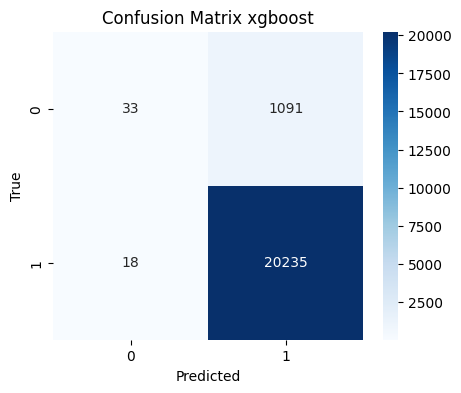

In [72]:
# Confusion matrix untuk validasi logistic regression
show_confusion_matrix(
    0,
    validate_information['name'][x],
    validate_information,
    y_val
)

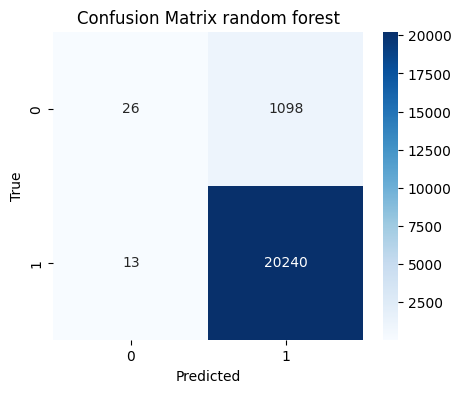

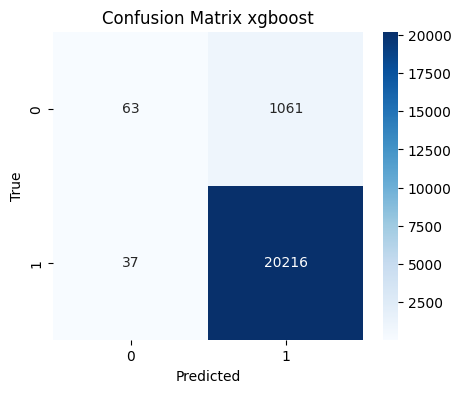

In [73]:
# Confusion matrix untuk validasi random forest dan xgboost
length = len(validate_information['name'])
for x in range(1, length):
  show_confusion_matrix(
      x,
      validate_information['name'][x],
      validate_information,
      y_val
  )

##### Testing

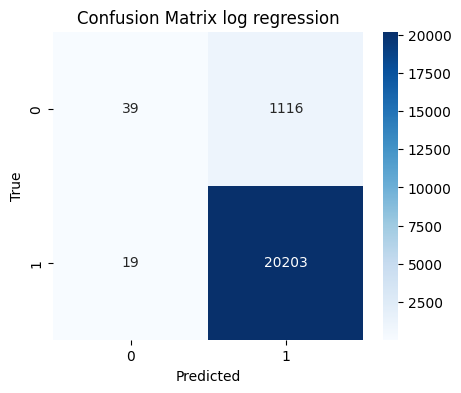

In [79]:
# Confusion matrix untuk testing logistic regression
show_confusion_matrix(
    0,
    testing_information['name'][0],
    testing_information,
    y_test
)

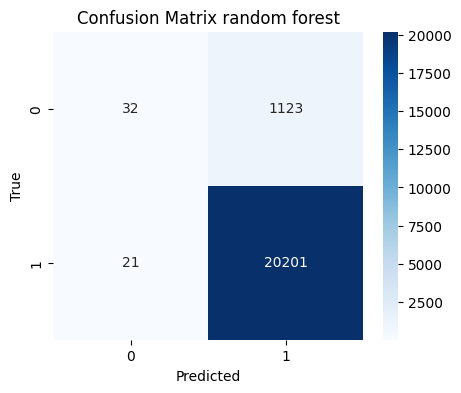

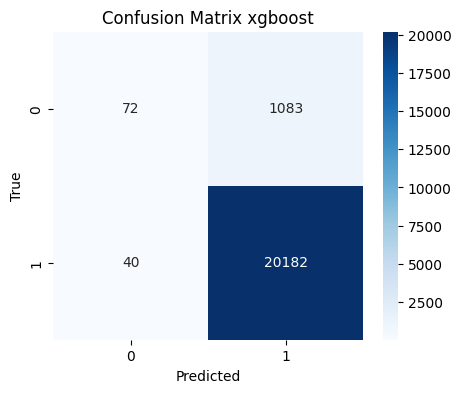

In [75]:
# Confusion matrix untuk testing random forest dan xgboost
length = len(testing_information['name'])
for x in range(1, length):
  show_confusion_matrix(
      x,
      testing_information['name'][x],
      testing_information,
      y_test
  )

* Model Logistic Regression:

Nilai True Positif sebesar 20203, berarti terdapat 20203 yang diprediksi good
dengan real nya good

Nilai True Negatif sebesar 39, berarti terdapat 39 yang diprediksi bad dengan real nya bad

Nilai False Positif sebesar 1116, berarti terdapat 1116 yang diprediksi good tetapi real nya bad

Nilai False Negatif sebesar 19, berarti terdapat 19 yang diprediksi bad tetapi real nya good


* Model Random Forest:

Nilai True Positif sebesar 20201, berarti terdapat 20201 yang diprediksi good dengan real nya good

Nilai True Negatif sebesar 32, berarti terdapat 32 yang diprediksi bad dengan real nya bad

Nilai False Positif sebesar 1123, berarti terdapat 1123 yang diprediksi good tetapi real nya bad

Nilai False Negatif sebesar 21, berarti terdapat 21 yang diprediksi bad tetapi real nya good


* Model XGBoost:

Nilai True Positif sebesar 20182, berarti terdapat 20182 yang diprediksi good dengan real nya good

Nilai True Negatif sebesar 72, berarti terdapat 72 yang diprediksi bad dengan real nya bad

Nilai False Positif sebesar 1083, berarti terdapat 1083 yang diprediksi good tetapi real nya bad

Nilai False Negatif sebesar 40, berarti terdapat 40 yang diprediksi bad tetapi real nya good

### ROC Curve

In [76]:
def show_roc_curve(model, model_name, X_test_data, y_test_data):
    # Predict probabilities for the test set
    y_probs = model.predict_proba(X_test_data)[:, 1]  # Probabilities of the positive class

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_data, y_probs)

    # Calculate AUC
    auc = roc_auc_score(y_test_data, y_probs)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - ' + model_name)
    plt.legend(loc="lower right")
    # plt.grid(True)
    plt.show()

##### Validation

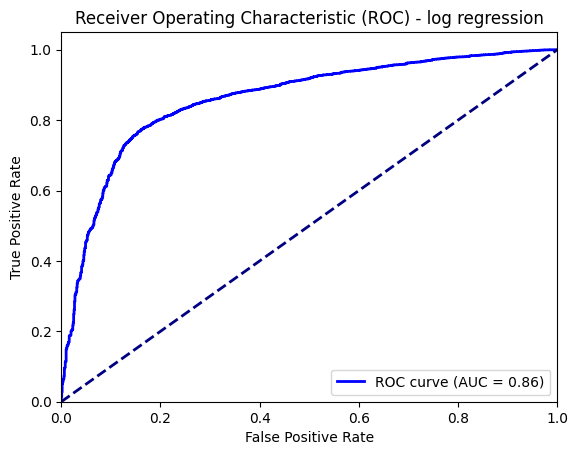

In [77]:
# Logistic Regression Validate ROC Curve
show_roc_curve(
    lr_grid,
    model_name = 'log regression',
    X_test_data = X_val_log,
    y_test_data = y_val_log
)

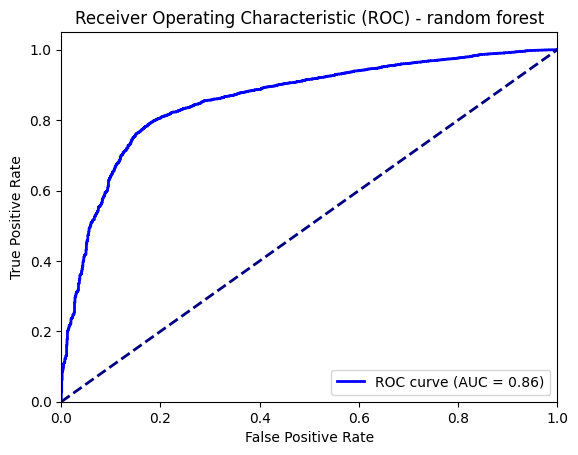

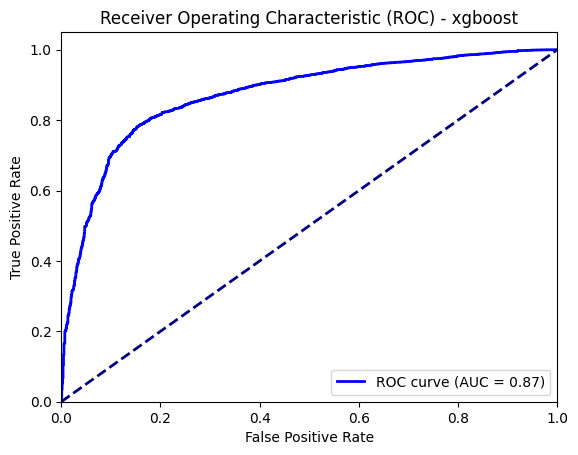

In [78]:
length = len(training_information['name'])
for x in range(1, length):
    show_roc_curve(
        training_information['model'][x],
        training_information['name'][x],
        X_test_data = X_val,
        y_test_data = y_val,
    )

##### Testing

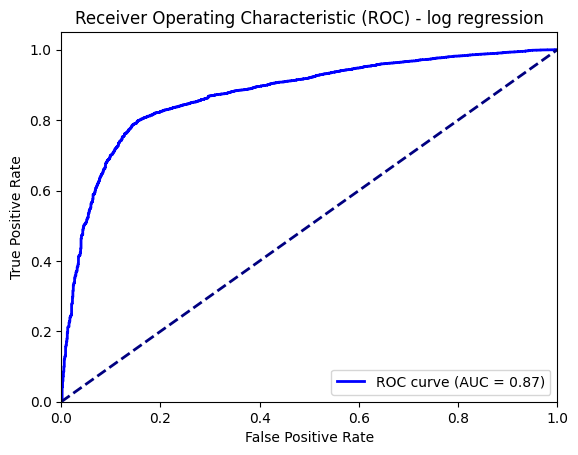

In [80]:
# Logistic Regression Testing ROC Curve
show_roc_curve(
    lr_grid,
    model_name = 'log regression',
    X_test_data = X_test_log,
    y_test_data = y_test_log,
)

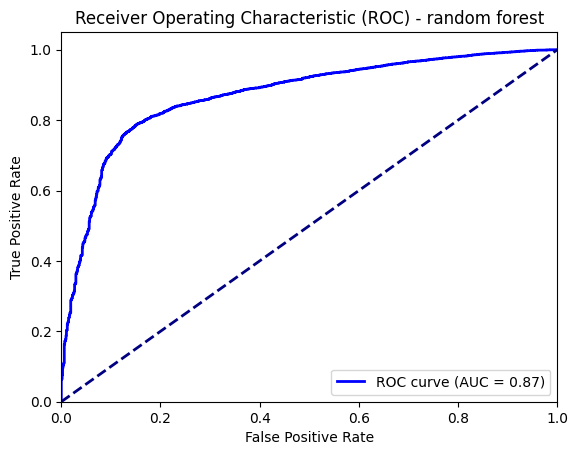

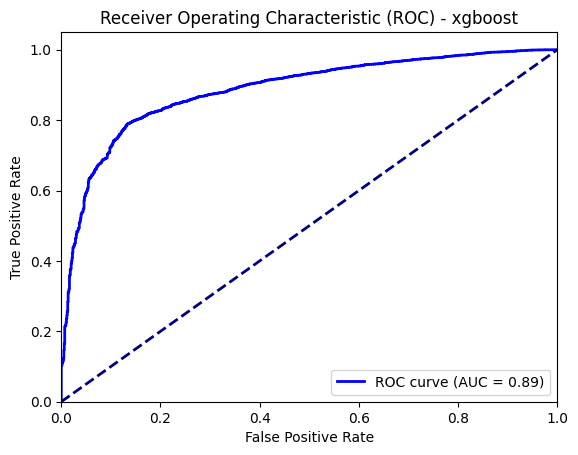

In [81]:
length = len(training_information['name'])
for x in range(1, length):
    show_roc_curve(
        training_information['model'][x],
        training_information['name'][x],
        X_test_data = X_test,
        y_test_data = y_test,
    )

#Conclusion

Berdasarkan proses data understanding, preprocesing data, eksploratory data analysis sampai dilakukan tahap pemodelan machine learning yang telah dilakukan dengan logistic regression dengan dilakukan proses PCA serta Random Forest dan XGBoost tanpa dilakukan proses PCA dapat disimpulkan bahwa:
Model lebih mengutamakan recall disbanding precision, karena lebih baik False Negatif yang kecil dibandingkan banyaknya False Positif pada Confusion matrix  nya, dikarena **lebih baik** memprediksi **status credit good** tetapi realnya **bad** dibandingkan diprediksi **bad** tetapi realnya **good**. Sehingga model XGBoost tanpa proses PCA lebih baik dalam recall nya dibandingkan model Random Forest tanpa proses PCA dan logistic regresion dengan proses PCA.


Nilai ROC AUC terbesar ada pada model XGBoost yaitu sebesar 0,89 dengan kurva ROC lebih condong ke kiri atas. Hal ini menunjukkan bahwa model XGBoost memiliki kinerja yang baik dalam membedakan antara kelas positif yaitu good dan negatif yaitu bad. Ini berarti bahwa model memiliki probabilitas 89% untuk memberikan skor yang lebih tinggi kepada contoh positif dibandingkan dengan contoh negatif secara acak. Nilai ini mengindikasikan bahwa model XGBoost cukup handal digunakan dalam klasifikasi.

Sehingga model XGBoost dapat menjadi pilihan terbaik dari segi recall, F-1 Score, dan nilai ROC AUC dalam klasifikasi kriteria nasabah yang good dengan nasabah yang bad untuk penentuan dapat diizinkan untuk credit atau tidak oleh Bank. Maka model XGBoost dapat **meningkatkan keakuratan** dalam ***menilai dan mengelola risiko kredit***, sehingga multifinance selaku client dari id/x partners dapat mengoptimalkan keputusan bisnis mereka dan mengurangi potensi kerugian.